# Calculating gradients and curl on the ECCO native grid

*Contributors*: [Ian Fenty](https://github.com/ifenty), [Andrew Delman](https://github.com/andrewdelman) (ed.).

## Objectives

1. Learn how to calculate zonal and meridional gradients from scalar and vector fields from ECCO fields on the lat-lon-cap (llc) model grid

2. Learn how to save these interpolated fields as netCDF for later analysis 

## Introduction

Before we calculate zonal and meridional gradients, recall that some of the 13 tiles of the ECCO model's llc grid are rotated relative to each other and that the x and y axes of the model tiles do not align with parallels and meridians. 

![llc90 tile layout](../figures/llc90_0.png)

The layout above shows how each tile is oriented with respect to the model's internal 'x' and 'y' axes. Our job here is to show how to calculate zonal and meridional gradients from scalar and vector fields provided in this complex model geometry. Specifically, in this tutorial we'll demonstrate how to calculate the zonal and meridional gradients of three types of ECCO fields on the native grid:
1. scalar fields (e.g., temperature, salinity)
2. vector fields provided on the model 'u' and 'v' points (e.g., horizonal ocean and sea-ice velocity)
3. vector fields provided on the model tracer points (e.g., atmosphere wind and wind stress)

To reproduce the notebook you'll need the ECCO llc grid geometry file and granules from the following datasets (for Jan-Dec 2000):

- **ECCO_L4_GEOMETRY_LLC0090GRID_V4R4**
- **ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4**
- **ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4**
- **ECCO_L4_ATM_STATE_LLC0090GRID_MONTHLY_V4R4**

We first demonstrate how to calculate zonal/meridional gradients of scalar fields, then gradients of vector fields provided at model 'u' and 'v' points, and finally gradients of vector fields provided at model tracer points (using atmosphere surface winds)

## Preliminaries

### Prepare the working enviornment

In [1]:
import cartopy as cartopy
import cartopy.crs as ccrs
import glob
import importlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from pathlib import Path
from pprint import pprint
import sys
import xarray as xr
import xgcm as xgcm
import warnings


# set incloud_access = True if accessing ECCO datasets from an EC2 instance in the cloud, otherwise False
incloud_access = True


warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
## Import the ecco_v4_py library into Python
## =========================================
##    If ecco_v4_py is not installed in your local Python library, 
##    tell Python where to find it.  The example below adds
##    ecco_v4_py to the user's path if it is stored in the folder
##    ECCOv4-py under the user's home directory

from os.path import join,expanduser
user_home_dir = expanduser('~')
print(join(user_home_dir,'ECCOv4-py'))
sys.path.append(join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
from ecco_v4_py import get_llc_grid as get_llc_grid
from ecco_v4_py import plot_proj_to_latlon_grid
# define some useful colormaps where NaNs are black
colMap = cm.RdBu_r
colMap.set_bad(color='black')

jet_colMap_k = cm.jet
jet_colMap_k.set_bad(color='black')

jet_colMap_w = cm.jet
jet_colMap_w.set_bad(color='white')

C:\Users\adelman\ECCOv4-py


In [3]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================

## currently set to ~/Downloads/ECCO_V4r4_PODAAC, 
## the default if ecco_podaac_download was used to download dataset granules
    
ECCO_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')
print(ECCO_dir)

C:\Users\adelman\Downloads\ECCO_V4r4_PODAAC


In [4]:
## open ECCO datasets needed for the tutorial (without loading them into memory yet)

ShortNames_list = ["ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                   "ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4",\
                   "ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4",\
                   "ECCO_L4_ATM_STATE_LLC0090GRID_MONTHLY_V4R4"]
if incloud_access == True:
    from ecco_s3_retrieve import ecco_podaac_s3_get_diskaware
    files_nested_list = ecco_podaac_s3_get_diskaware(ShortNames=ShortNames_list,\
                                                     StartDate='2000-01',EndDate='2000-12',\
                                                     max_avail_frac=0.5,\
                                                     download_root_dir=ECCO_dir)
    ecco_grid = xr.open_mfdataset(files_nested_list[ShortNames_list[0]])
    ecco_vars_TS = xr.open_mfdataset(files_nested_list[ShortNames_list[1]],compat='override',data_vars='minimal',coords='minimal')
    ecco_vars_vel = xr.open_mfdataset(files_nested_list[ShortNames_list[2]],compat='override',data_vars='minimal',coords='minimal')
    ecco_vars_atm = xr.open_mfdataset(files_nested_list[ShortNames_list[3]],compat='override',data_vars='minimal',coords='minimal')
else:
    ecco_grid = xr.open_mfdataset(glob.glob(join(ECCO_dir,ShortNames_list[0],'*.nc'))[0])
    ecco_vars_TS = xr.open_mfdataset(glob.glob(join(ECCO_dir,ShortNames_list[1],'*2000-*.nc')),\
                                     compat='override',data_vars='minimal',coords='minimal')
    ecco_vars_vel = xr.open_mfdataset(glob.glob(join(ECCO_dir,ShortNames_list[2],'*2000-*.nc')),\
                                     compat='override',data_vars='minimal',coords='minimal')
    ecco_vars_atm = xr.open_mfdataset(glob.glob(join(ECCO_dir,ShortNames_list[3],'*2000-*.nc')),\
                                      compat='override',data_vars='minimal',coords='minimal')

### Load ECCO Geometry

First, load the llc model grid geometry.

In [5]:
## Load the model grid
ecco_grid = ecco_grid.compute()

### Rotating between the model's vector basis and vector basis of parallels ($\lambda$) and meridians ($\phi$)

To calculate zonal and meridional gradients from ECCO fields on the lat-lon-cap grid we need to rotate vectors. In general it is easier and more accurate to first calculate our gradient vectors with respect to the orthogonal basis $M$ defined by the local $[x,y]$ coordinates of the model grid. The horizonal gradient of field, $f$ in the model basis is a vector comprised of the gradient in the local $x$ and $y$ directions in $M$.

$\nabla_M f =[\partial_x f, \partial_y f]_M$

Once we know $\nabla_M f$, we can rotate the gradient vectors to the orthogonal basis $G$ of meridians and parallels. Rotation to $G$ from $M$ is accomplished via the change of basis matrix, $S_{M→G}$.\
$S_{M→G} [\partial_x f, \partial_y f]_M  = [\partial_x f, \partial_y f]_G $

After the change of basis, the vector $[\partial_x f, \partial_y f]_G$ contains the gradients of $f$ with respect to the zonal ($x:\lambda$) and meridional ($y:\phi$) directions, respectively. The subscripts $M$ and $G$ denote the basis of the vector.

The change of basis matrix $S_{M→G}$ is a square, orthogonal rotation matrix. Rotating vectors from the model's orthogonal $M$ basis to the orthogonal $G$ basis of meridians and parallels requires knowing the angle between their axes.

Define **$\theta$** as the angle between a unit vector in a grid cell's $\hat{y}_M$ direction and a unit vector in the corresponding meridional direction, $\hat{\phi}$ of that grid cell. These angles vary continually between grid cells and across tiles. The ECCO model grid geometry provides $cos(\theta)$ in the variable *CS* and $sin(\theta)$ in the variable *SN*. *CS* and *SN* are defined by:

$cos(\theta) = \hat\phi_M \cdot \hat{y}_M$\
$sin(\theta) = \hat\phi_M \cdot \hat{x}_M$

Where the $M$ subscript conveys that all vectors are written in the basis of the model grid.

Let's illustrate $\theta$ in two cases:(1) $M$ and $G$ are aligned and (2) $M$ and $G$ are perpendicular. 

**Case 1: aligned basis**

In tiles 1 and 4, unit vectors in the $\hat{y}_M$ direction, $\hat{y}_M = [0, 1]_M$ are parallel with unit vectors in the meridional $\hat\phi_M$ direction, $\hat\phi_M = [0, 1]_M$. Consequently,
1. $cos(\theta) = [0, 1] \cdot [0, 1] = [0\times0 + 1\times1] = 1$
1. $sin(\theta) = [0, 1] \cdot [1, 0] = [0\times1 + 1\times0] = 0$
1. $\theta = 0$

**Case 2: perpendicular basis**

In tiles 8 and 11, unit vectors in the $\hat{y}_M$ direction, $\hat{y}_M = [0, 1]_M$ are rotated 90 degrees clockwise relative to unit vectors in the meridional $\hat\phi_M$ direction. In fact, $\hat{\phi}_M$ is in the -$\hat{x}_M$ direction and therefore we write $\hat\phi_M = [-1, 0]_M$. Consequently,
1. $cos(\theta) = [-1, 0] \cdot [0,1] = [-1\times0 + 0\times1]=0$
1. $sin(\theta) = [-1, 0] \cdot [1, 0] = [-1\times1 + 0\times0] = -1$
1. $\theta=-\pi/2$ 

Knowing $\theta$, *CS*, and *SN* we can define the rotation matrix as (see https://en.wikipedia.org/wiki/Rotation_matrix):

$S_{M→G} =\begin{bmatrix}cos(\theta) & -sin(\theta)\\\ sin(\theta) & cos(\theta)\end{bmatrix}$


Application of the change of basis matrix to a gradient vector in the model basis $M$ yields the gradients in the basis of meridians and parallels $G$. 

$\begin{bmatrix}\partial_x f\\\ \partial_y f \end{bmatrix}_G =\begin{bmatrix}cos(\theta) & -sin(\theta)\\\ sin(\theta) & cos(\theta)\end{bmatrix}\begin{bmatrix}\partial_x f\\\ \partial_y f \end{bmatrix}_M$

**Zonal gradient** of $f$:

$[\partial_x f]_G       = [\partial_x f]_M \, cos(\theta) - [\partial_y f]_M \, sin(\theta)$

**Meridional gradient** of $f$:

$[\partial_y f]_G       = [\partial_x f]_M \, sin(\theta) + [\partial_y f]_M \, cos(\theta)$

#### Plotting $sin(\theta)$ and $cos(\theta)$
Plotting $SN$ and $CS$, shows the expected values for tiles 1 and 4 where $\theta=0$: $sin(\theta)=0$ and $cos(\theta)=1$ and the expected values for tiles 8 and 11 where $\theta=-\pi/2$: $sin(\theta)=-1$ and $cos(\theta)=0$

Further variations of the sines and cosines of $\theta$ reveals the warping of the tile grids onto the sphere. The most interesting sine and cosine patterns are seen in tile 6. Take a moment to convince yourself that $SN$ and $CS$ in tile 6 make sense.

In [6]:
help(ecco.plot_tiles)

Help on function plot_tiles in module ecco_v4_py.tile_plot:

plot_tiles(tiles, cmap=None, layout='llc', rotate_to_latlon=False, Arctic_cap_tile_location=2, show_colorbar=False, show_cbar_label=False, show_tile_labels=True, cbar_label='', fig_size=9, less_output=True, **kwargs)
    Plots the 13 tiles of the lat-lon-cap (LLC) grid
    
    Parameters
    ----------
    tiles : numpy.ndarray or dask.array.core.Array or xarray.core.dataarray.DataArray
        an array of n=1..13 tiles of dimension n x llc x llc 
    
            - If *xarray DataArray* or *dask Array* tiles are accessed via *tiles.sel(tile=n)*
            - If *numpy ndarray* tiles are acceed via [tile,:,:] and thus n must be 13.
    
    cmap : matplotlib.colors.Colormap, optional
        see plot_utils.assign_colormap for default
        a colormap for the figure
    
    layout : string, optional, default 'llc'
        a code indicating the layout of the tiles
    
        :llc:    situates tiles in a fan-like manner wh

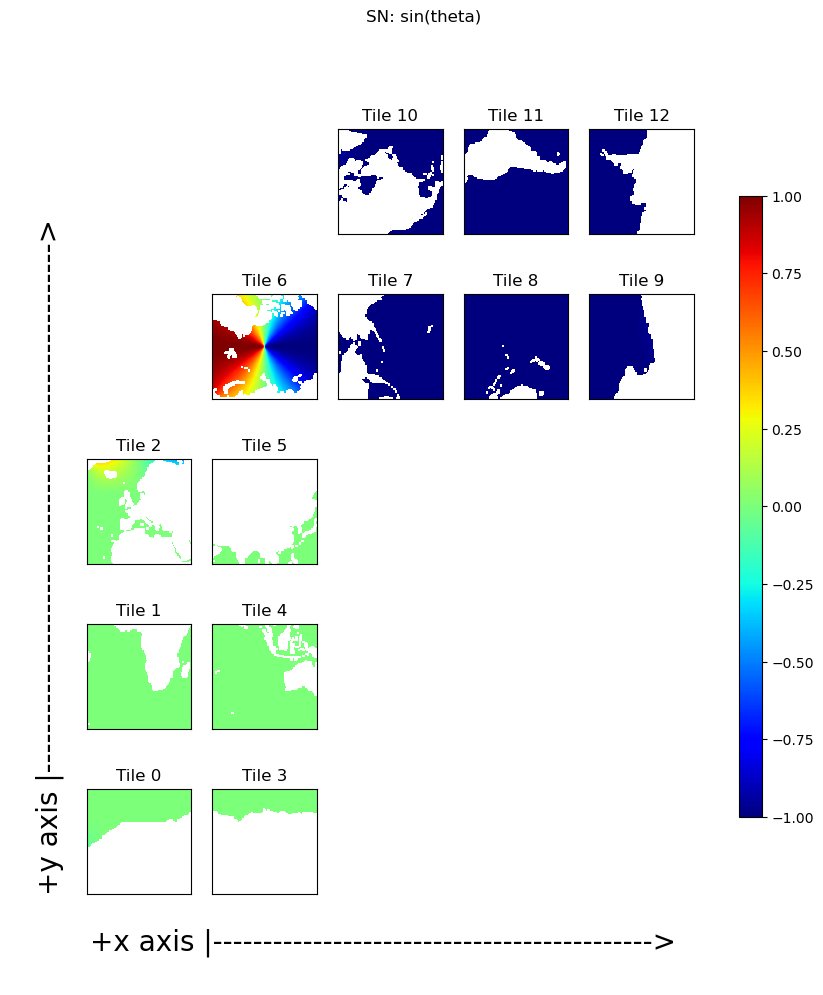

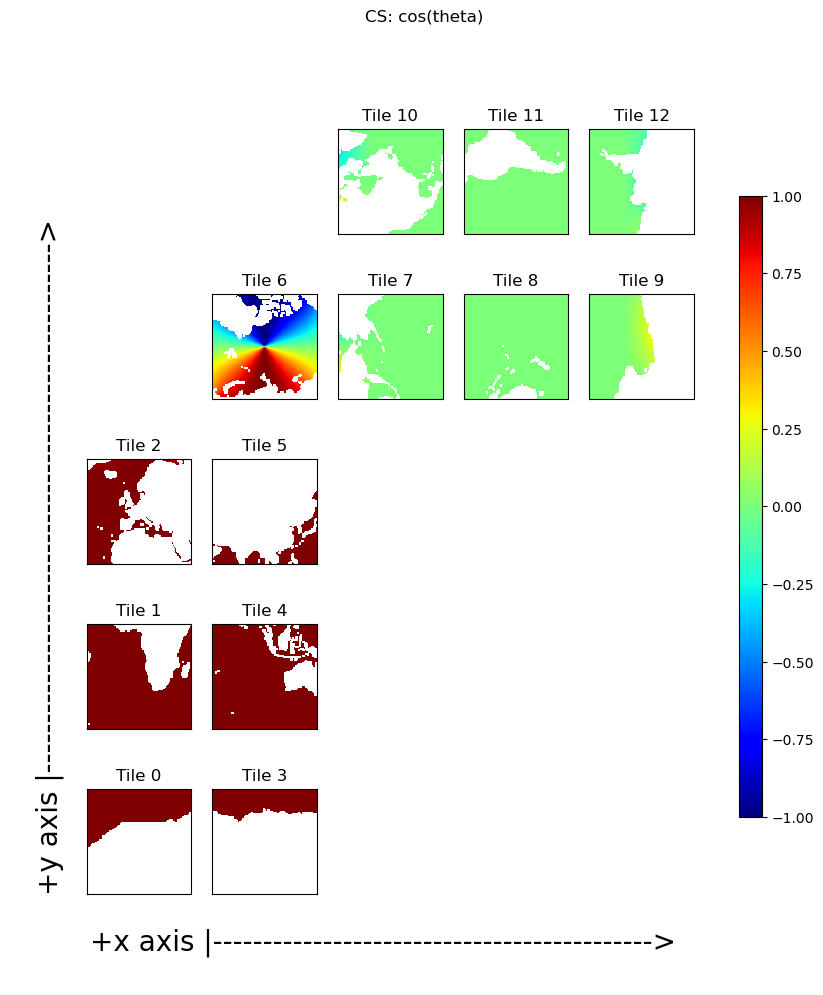

In [7]:
plt.rcParams['text.usetex'] = False
X = ecco.plot_tiles(ecco_grid.SN.where(ecco_grid.maskC.isel(k=0)), 
                    show_colorbar=True, show_tile_labels=True, cmap=jet_colMap_w);
fig=X[0]
ax=fig.get_axes()[-1]
fig.suptitle('SN: sin(theta)')
ax.annotate('+x axis |-------------------------------------------->',
            xy=(.1, .065), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20);
yd= 0.75
ax.annotate('+y axis |----------------------------------------------------->',
            xy=(.04, yd), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',rotation=90,
            fontsize=20);

X = ecco.plot_tiles(ecco_grid.CS.where(ecco_grid.maskC.isel(k=0)), 
                    show_colorbar=True, show_tile_labels=True, cmap=jet_colMap_w);
fig=X[0]
ax=fig.get_axes()[-1]
fig.suptitle('CS: cos(theta)')
ax.annotate('+x axis |-------------------------------------------->',
            xy=(.1, .065), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20);
yd= 0.75
ax.annotate('+y axis |----------------------------------------------------->',
            xy=(.04, yd), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',rotation=90,
            fontsize=20);

### The logical connection between geographically adjacent tile edges

To calculate gradients for grid cells on the edges of model tiles we will need information from from logically adjacent tiles. For example, to calculate zonal gradients along the eastern edge of Tile 1 we need information found along the western edge of Tile 4 (i.e., we need to difference the field in the last column of Tile 1 and the first column of Tile 4) and gradients across the western edge of Tile 4 need information found along the eastern edge of Tile 8 (i.e., we need to difference the field in the last column of Tile 4 and the reversed first row of Tile 8). Managing these connections requires careful bookkeeping.  Fortunately the 'xgcm' Python library (https://xgcm.readthedocs.io/en/latest/) allows us to construct a logical map that specifies the logical relation between tiles. *So useful!*. 

To create the logical mapping for the ECCO llc grid we provide a helper routine, *get_llc_grid*: 

In [8]:
# Make the XGCM object
XGCM_grid = get_llc_grid(ecco_grid)

# look at the XGCM object.
print(XGCM_grid)

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center
Z Axis (not periodic, boundary=None):
  * center   k --> left
  * right    k_u --> center
  * left     k_l --> center
  * outer    k_p1 --> center
Y Axis (not periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center


Note: the **X** axis is defined by $i$ and $i_g$ grid indices while the  ***Y*** axis is defined by the $j$ and $j_g$ grid indices.

Now that we have the XGCM local grid object, the difference between adjacent rows or columns in tile arrays can be calculated using the xgcm *diff* subroutine. To convert local differences to gradients we specify the spacing between adjacent grid cells. The distances between adjacent grid cell *centers* are contained in the $dxC$ and $dyC$ fields of the ECCO grid dataset, respectively.

See https://xgcm.readthedocs.io/en/latest/api.html#xgcm.Grid.diff for more details about the 'diff' function

Now that we have been introduced to the $SN$ and $CS$ rotation factors and the **XGCM_grid** object we can proceed!

## Calculating zonal and meridional gradients of **scalar** ECCO fields located at tracer cell points

### Load the model granules

In [9]:
## Load monthly potential temperature & salinity from 2000

## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_ds = xr.merge((ecco_grid , ecco_vars_TS)).compute()

# these granules have both potential temperature and salinity
print(list(ecco_vars_TS.data_vars))
print(f"dims of theta: {ecco_vars_TS['THETA'].dims}")

['THETA', 'SALT']
dims of theta: ('time', 'k', 'tile', 'j', 'i')


In [10]:
# Select out the ocean surface salinity field 
s = ecco_ds.SALT.isel(k=0, time=0).copy(deep=True)

# set land points to nan because the salinity gradients
# between land and sea are not meaningful
# ...k=0 selects the first vertical level
# ...the where command preserves values that meet the conditional 
# (maskC > 0) and turns values that fail the conditional to NaN.
nan_land_mask = ecco_ds.maskC.where(ecco_ds.maskC.isel(k=0) > 0);

# mask land points of the salinity field 
s = s*nan_land_mask.isel(k=0)

print(f'sss field time: {s.time.values}')

# confirm that the field is indeed in the native grid format (13 tiles of 90x90)
print(f'\nsss dimensions: {s.dims}')
print(f'sss shape: {s.shape}')

sss field time: 2000-01-16T12:00:00.000000000

sss dimensions: ('tile', 'j', 'i')
sss shape: (13, 90, 90)


### Plot SSS field

To get oriented, first let's plot native grid the SSS field on a Robinson projection. Take note of some of the large-scale zonal and meridional gradients. For example, the zonal gradient from the western N. Atlantic subpolar gyre to the NE Atlantic is positive and the meridional gradients from the Weddell Sea in the Southern Ocean to the S. Atlantic subpotropical gyre center is broadly positive. We'll check that the zonal and meridional gradients we calculate agree with our expectations.

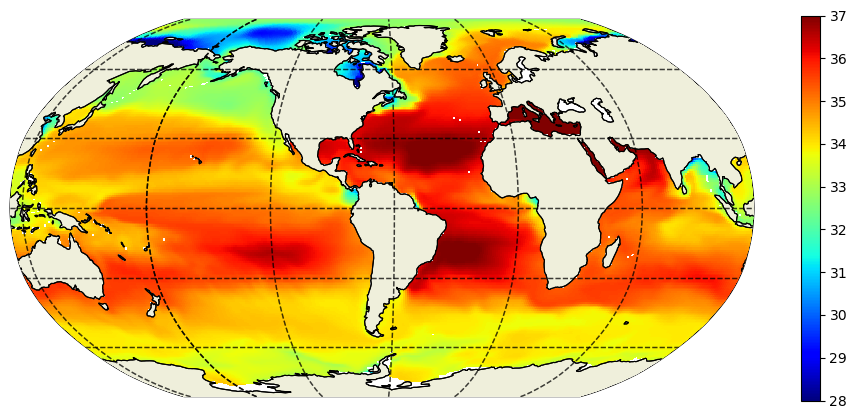

In [11]:
plt.figure(figsize=[12,5]);
X = plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, s, 
                                  cmin=28, cmax=37,cmap=jet_colMap_w,
                                  show_colorbar=True, user_lon_0=-66)

In [12]:
from ecco_v4_py import resample_to_latlon

In [13]:
X = resample_to_latlon(ecco_grid.XC, ecco_grid.YC, s, -90, 90, 1, -180, 180, 1,
                      radius_of_influence=200e3)

In [14]:
print(X[0][0,0])
print(X[0][-1,-1])

-179.5
179.5


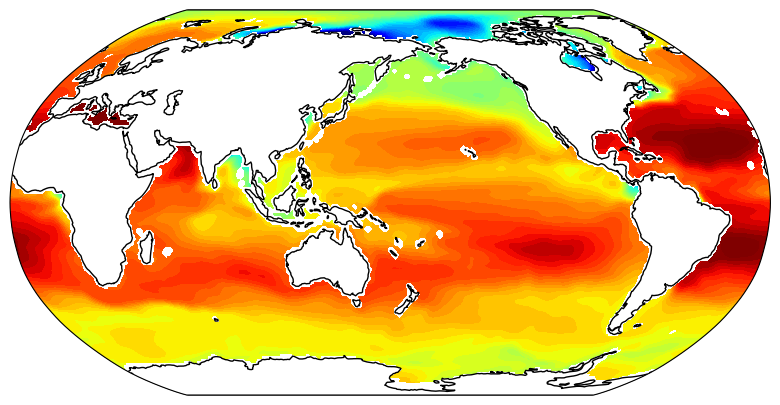

In [15]:
cm_lon=-196;
rob_proj = cartopy.crs.Robinson(central_longitude=cm_lon)
#data_proj = ccrs.PlateCarree(central_longitude = cm_lon)
data_proj = ccrs.PlateCarree(central_longitude = 0)
fig = plt.figure(figsize=(12,5))

ext = [-180-cm_lon, 180-cm_lon, -90, 90]

ax = fig.add_subplot(111, projection=rob_proj)
ax.coastlines()

# topo_plot = ax.pcolormesh(X[2],\
#                           X[3],\
#                           X[4],vmin=33,vmax=36,
#                           transform=data_proj)#,antialiased=True)

ax = fig.add_subplot(111, projection=rob_proj)
ax.coastlines()
import cartopy.util as cutil
cdata, clon, clat = cutil.add_cyclic(X[4], X[0], X[1])
topo_plot = ax.contourf(clon, clat, cdata,vmin=28,vmax=37,cmap=jet_colMap_w,extend='both',\
                        levels=np.arange(28,37.2,.2),\
                          transform=data_proj)#,antialiased=True)

Now plot the same field but this time as 13 tiles in the llc90 native model grid layout:

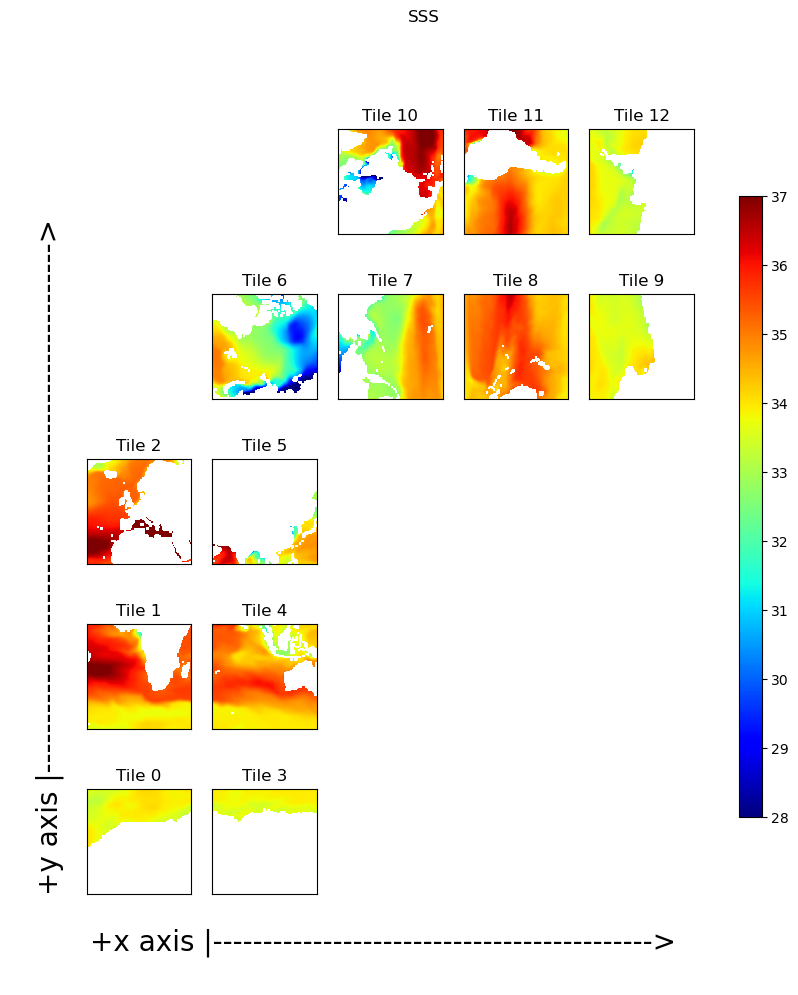

In [16]:
X = ecco.plot_tiles(s, cmin=28,cmax=37, show_colorbar=True, show_tile_labels=True, 
                    cmap=jet_colMap_w);
fig=X[0]
fig.suptitle('SSS')
ax=fig.get_axes()[-1]
ax.annotate('+x axis |-------------------------------------------->',
            xy=(.1, .065), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20);
yd= 0.75
ax.annotate('+y axis |----------------------------------------------------->',
            xy=(.04, yd), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',rotation=90,
            fontsize=20);

### Calculate the gradients of the scalar field with respect with the model grid's basis $[\hat{x}, \hat{y}]_M$

Here we calculate gradients using first-order differences:

$ds/dx = [s(x+h) - s(x)]/h$


with $h$ being the distance between neighboring values of $s$ on the model grid. In practice, we difference adjacent rows or columns of the tile arrays.  

The calculate the difference between adjacent rows or columns of ECCO llc tiles we make use of the xgcm 'diff' subroutine. After calculating hte differences between adjacent values, we divide by the distances between them. 

In the case of scalar fields defined at model tracer points $[i,j]$, the distance between adjacent grid cell centers are provided by the $dxC$ and $dyC$ fields of the ECCO grid dataset, respectively.

See https://xgcm.readthedocs.io/en/latest/api.html#xgcm.Grid.diff for more details about the 'diff' function

#### Gradient of the scalar field in the $\hat{x}_M$ direction:

To calculate the gradient of the tracer field $s$ in the $\hat{x}_M$ direction we need the difference between adjacent grid cells in the $\hat{x}_M$ direction and the distances between them.

The xgcm *diff* routine applied in the $\hat{x}_M$ direction of scalar field $s$ defined on $[i,j]$ (tracer) points will calculate differences between $s(i,j)$ and $s(i-1,j)$.

We consider the difference of $s(i,j)$ and $s(i-1,j)$ to be "located" 1/2 step between them at $[i-1/2, j]$. In the terminology of the xgcm package, the index $i-1/2$ is considered to be to the "left" of $i$ and the index $j-1/2$ is considered to the "left" of $j$. Notably, $[i-1/2, j]$ location is also known as the 'u' point of the tracer cell at $[i,j]$. 'u' points use a special index: $[i_g, j]$. To be explicit, 1/2 step to the "left" of $[i=0,j]$ is $[i_g=0,j]$ while 1/2 step to the "right" of $[i=0,j]$ is $[i_g=1,j]$.

The distance between $s(i,j)$ and $s(i-1,j)$ is "located" between them at $dxC(i_g, j)$. In MITgcm terminology, $dxC$ defined as "the length of the northern edge of the vorticity cell". The "vorticity cell" is located at $[i_g, j_g]$, 1/2 to the 'left' of $[i,j]$ in both $\hat{x}_M$ and $\hat{y}_M$. Furthermore, the length of the "northern" edge of the vorticity cell at $[i_g, j_g]$ is the distance between tracer cell centers at $[i,j]$ and $[i-1,j]$. Exactly what is needed here.

Confirm that the distance between adajcent tracer grid cell centers in $\hat{x}_M$ is situated "between" them at $[i_g, j]$:

In [17]:
print(f'dxC dimesions: {ecco_ds.dxC.dims}')

dxC dimesions: ('tile', 'j', 'i_g')


In [18]:
# calculate the gradient of s in 'X': 

# step 1 
# ... the difference in adjacent grid cells at [i,j] and [i-1, j] in the 'x' direction, 
# ... ds denotes the difference in field s
# ... the _hatx suffix denotes that the difference is in the '\hat{x}' direction.
# ... the _M suffix denotes we are working in the model basis
ds_hatx_M = XGCM_grid.diff(s, 'X')

# step 2
# ... divide by the distance between 
# ... ds_dx denotes the derivative of field s with respect to distance in meters
# ... the _hatx suffix denotes that the gradient is in the '\hat{x}' direction.
ds_dx_hatx_M = ds_hatx_M / ecco_ds.dxC

print(f'dimensions of ds_hatx_M    : {ds_hatx_M.dims}')
print(f'dimensions of ds_dx_hatx_M : {ds_dx_hatx_M.dims}')

dimensions of ds_hatx_M    : ('tile', 'j', 'i_g')
dimensions of ds_dx_hatx_M : ('tile', 'j', 'i_g')


#### Gradient of the scalar field in the $\hat{y}_M$ direction:

We can apply the same reasoning for gradients in $\hat{y}_M$ direction. 

To calculate the gradient of the tracer field $s$ in the $\hat{y}_M$ direction we need the difference between adjacent grid cells in the $\hat{y}_M$ direction and the distances between them.

The xgcm *diff* routine applied in the $\hat{y}_M$ direction of scalar field $s$ defined on $[i,j]$ (tracer) points will calculate differences between $s(i,j)$ and $s(i,j-1)$.

We consider the difference of $s(i,j)$ and $s(i,j-1)$ to be "located" 1/2 step between them at $[i, j-1/2]$. In the terminology of the xgcm package, the index $j-1/2$ is considered to be to the "left" of $j$. Notably, $[i, j-1/2]$ location is also known as the 'v' point of the tracer cell at $[i,j]$. 'v' points use a special index: $[i, j_g]$. To be clear, 1/2 step to the "left" of $[i,j=0]$ is $[i, j_g=0]$ while 1/2 step to the "right" of $[i,j=0]$ is $[i,j_g=1]$.

The distance between $s(i,j)$ and $s(i,j-1)$ is "located" between them at $dyC(i, j_g)$. In MITgcm terminology, $dyC$ defined as "the length of the eastern edge of the vorticity cell". The "vorticity cell" is located at $[i_g, j_g]$, 1/2 to the 'left' of $[i,j]$ in both $\hat{x}_M$ and $\hat{y}_M$. Furthermore, the length of the "eastern" edge of the vorticity cell at $[i_g, j_g]$ is the distance between tracer cell centers at $[i,j]$ and $[i,j-1]$. Exactly what is needed here.

Confirm that the distance between adajcent tracer grid cell centers in $\hat{y}_M$ is situated "between" them at $[i, j_g]$:

In [19]:
print(f'dyC dims: {ecco_ds.dyC.dims}')

dyC dims: ('tile', 'j_g', 'i')


In [20]:
# calculate the gradient of s in 'Y': 

# step 1 
# ... the difference in adjacent grid cells at [i,j] and [i, j-1] in the 'y' direction, 
# ... ds denotes the difference in field s
# ... the _haty suffix denotes that the difference is in the '\hat{y}' direction.
# ... the _M suffix denotes we are working in the model basis

ds_haty_M = XGCM_grid.diff(s, 'Y')

# step 2
# ... divide by the distance between 
# ... ds_dx denotes the derivative of field s with respect to distance in meters
# ... the _hatx suffix denotes that the gradient is in the '\hat{y}' direction.
# ... the _M suffix denotes we are working in the model basis
ds_dy_haty_M = ds_haty_M / ecco_ds.dyC

print(f'dimensions of ds_haty      : {ds_haty_M.dims}')
print(f'dimensions of ds_dy_haty_M : {ds_dy_haty_M.dims}')

dimensions of ds_haty      : ('tile', 'j_g', 'i')
dimensions of ds_dy_haty_M : ('tile', 'j_g', 'i')


In [21]:
# Confirm the location of the gradients in 'X' and 'Y' are at the 'u' and 'v' points, respectively.
print(f'ds_dx_hatx_M: {ds_dx_hatx_M.shape, ds_dx_hatx_M.dims}')
print(f'ds_dy_haty_M: {ds_dy_haty_M.shape, ds_dy_haty_M.dims}')

ds_dx_hatx_M: ((13, 90, 90), ('tile', 'j', 'i_g'))
ds_dy_haty_M: ((13, 90, 90), ('tile', 'j_g', 'i'))


Technical aside: One can explicitly ask xgcm to calculate differences with respect to neighboring grid cells to the 'left' or 'right'. By default, diff calculates 'left' differences. For more info see https://xgcm.readthedocs.io/en/latest/_modules/xgcm/grid.html?highlight=diff

### Plot the gradients

Our two gradient fields are vectors: 
1. *ds_dx_hatx_M* points in the $\hat{x}_M$ direction
2. *ds_dy_haty_M* points in the $\hat{y}_M$ direction. 

It is worth examining these gradients and convincing ourselves that the patterns are sensible.

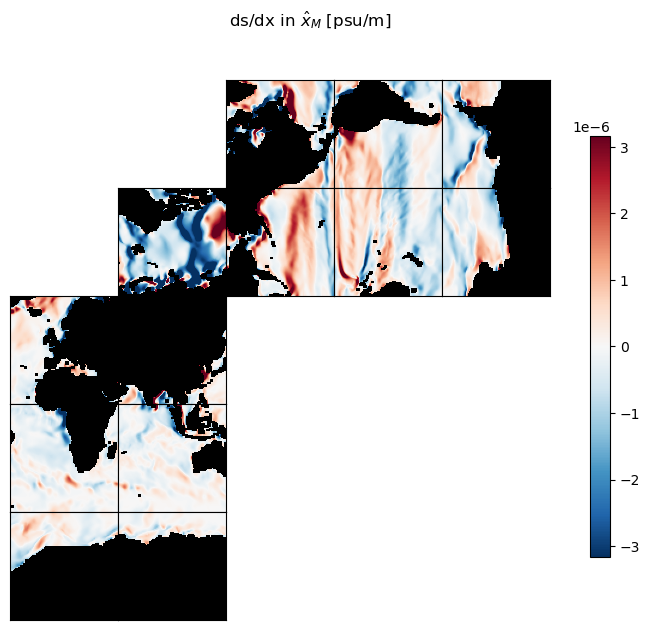

In [22]:
m=-5.5
ecco.plot_tiles(ds_dx_hatx_M, show_tile_labels=False, 
                cmin=-10**m, cmax=10**m, cmap=colMap,
                fig_size=8, show_colorbar=True);

plt.suptitle('ds/dx in $\hat{x}_M$ [psu/m]')
plt.show()

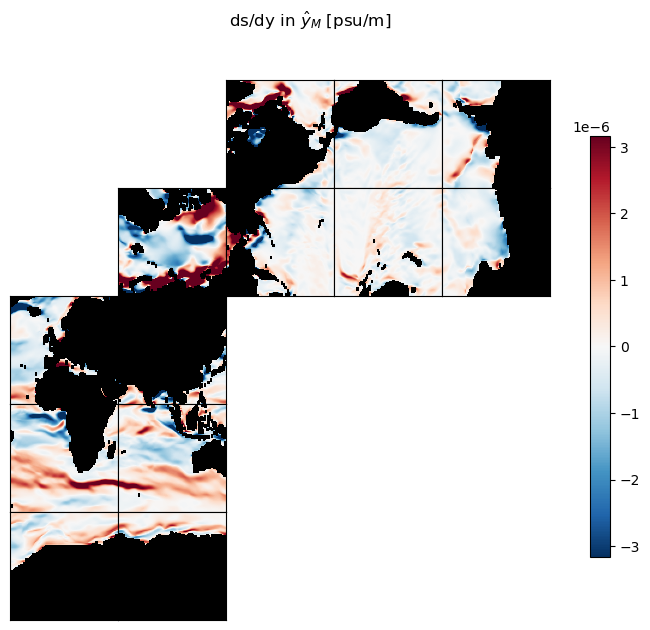

In [23]:
ecco.plot_tiles(ds_dy_haty_M, show_tile_labels=False, 
                cmin=-10**m, cmax=10**m, cmap=colMap,
                fig_size=8, show_colorbar=True);

plt.suptitle('ds/dy in $\hat{y}_M$ [psu/m]')
plt.show()

A reminder: *ds_dx_hatx_M* and *ds_dy_haty_M* have different grid coordinates than the scalar salinity field. While $s$ is located at $(i,j)$ tracer points, *ds_dx_hatx_M* is located at model 'u' points $(i_g, j)$ and *ds_dy_haty_M* is located at model 'v' points $(i,j_g)$.

In [24]:
d = np.datetime64('2001-12-01')
dm = np.datetime64(d, 'M')
dmp = np.datetime64(d, 'M')+1
print(dm, dmp)
print(np.datetime64(dmp,'ns'))

2001-12 2002-01
2002-01-01T00:00:00.000000000


In [25]:
print(f'dims of ds_dx_hatx_M: {ds_dx_hatx_M.dims}')
print(f'dims of ds_dy_haty_M: {ds_dy_haty_M.dims}')


dims of ds_dx_hatx_M: ('tile', 'j', 'i_g')
dims of ds_dy_haty_M: ('tile', 'j_g', 'i')


### Rotate the gradient vectors from the model grid basis to the basis of meridians and parallels

At this stage we have two gradient vectors, corresponding to the gradient of the scalar field $s$ with respect to distance in the model's $\hat{x}_M$ and $\hat{y}_M$ directions. Vector rotation is described in the "preliminary" section of this notebook.

Before we can find the meridional and zonal components of the gradients we first need to interpolate them to the tracer cell centers where $theta$ is defined. The xgcm library provides routine for interpolating the $\hat{x}_M$ and $\hat{y}_M$ components of a vector field from the 'u' and 'v' points to tracer cell centers:  *interp_2d_vector*. 

Note: a limitation of *interp_2d_vector* is that the vector located at the 'u' point must be in the $\hat{x}_M$ direction and the vector located on the 'v' point must be in the $\hat{y}_M$ direction. *ds_dx_hatx_M* and *ds_dy_haty_M* satisfy this requirement.

See https://xgcm.readthedocs.io/en/latest/api.html#xgcm.Grid.interp_2d_vector for more details about 'interp_2d_vector' 

#### Interpolate ds_dx and ds_dy to the grid cell centers

In [26]:
grad_s_at_cell_center = XGCM_grid.interp_2d_vector({'X': ds_dx_hatx_M, 'Y': ds_dy_haty_M}, boundary='fill')

*grad_s_at_cell_center* is a dictionary with the 'X' and 'Y' vector components interpolated to the cell centers

In [27]:
print(f'the keys of grad_s_at_cell_center are {list(grad_s_at_cell_center.keys() )}')

print(f"\nds_grad_vec X component {grad_s_at_cell_center['X'].dims}")
print(f"ds_grad_vec Y component {grad_s_at_cell_center['Y'].dims}")


the keys of grad_s_at_cell_center are ['X', 'Y']

ds_grad_vec X component ('tile', 'j', 'i')
ds_grad_vec Y component ('tile', 'j', 'i')


#### Rotation to zonal and meridional 
Finally, rotate the gradient vector to the basis of parallels and meridians to get the gradient in the zonal and meridional directions.

In [28]:
# The zonal component of the gradient vector:
# ... the gradient with respect to x in the G basis. 
ds_dx_hatx_G  = grad_s_at_cell_center['X']*ecco_grid['CS'] - \
                grad_s_at_cell_center['Y']*ecco_grid['SN']

# The meridional component of the gradient vector
# ... the gradient with respect to x in the G basis
ds_dy_haty_G  = grad_s_at_cell_center['X']*ecco_grid['SN'] + \
                grad_s_at_cell_center['Y']*ecco_grid['CS']

Our zonal and meridional gradient fields are xarray DataArray objects with the same coordinates and dimensions as all of our scalar fields:

In [29]:
# update the variable names
ds_dx_hatx_G.name = 'ds_dx_hatx_G'
ds_dy_haty_G.name = 'ds_dy_haty_G'

ds_dx_hatx_G.attrs.update({'long_name':'zonal gradient of SSS'})
ds_dy_haty_G.attrs.update({'long_name':'meridional gradient of SSS'})

#The gradients have units psu/m
ds_dx_hatx_G.attrs.update({'units':'psu m-1'})
ds_dy_haty_G.attrs.update({'units':'psu m-1'})

In [30]:
print('ds_dx_hatx_G:')
print(f'  dims: {ds_dx_hatx_G.dims}')
print(f'  shape: {ds_dx_hatx_G.shape}')

print('\nds_dy_haty_G:')
print(f'  dims: {ds_dy_haty_G.dims}')
print(f'  shape: {ds_dy_haty_G.shape}')

ds_dx_hatx_G:
  dims: ('tile', 'j', 'i')
  shape: (13, 90, 90)

ds_dy_haty_G:
  dims: ('tile', 'j', 'i')
  shape: (13, 90, 90)


### Plot the resulting zonal and meridional gradients

Now that we have gradients in the zonal and meridional directions, it makes more sense to plot the tiles in a 'lat-lon' layout.

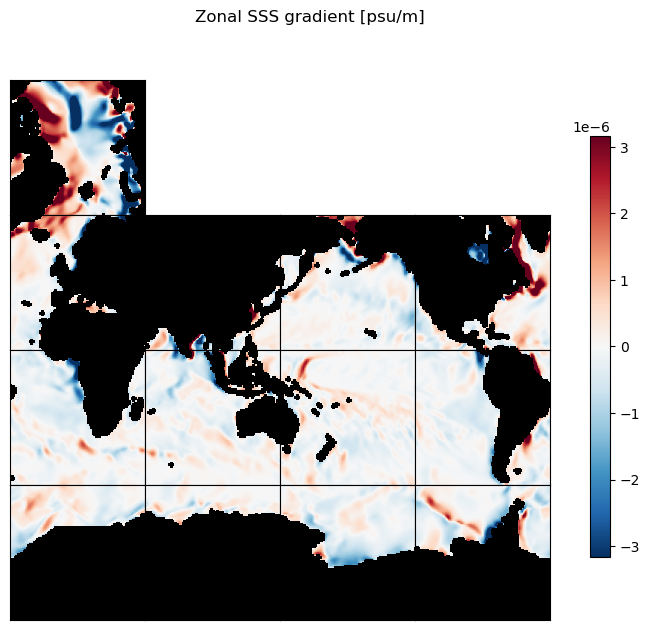

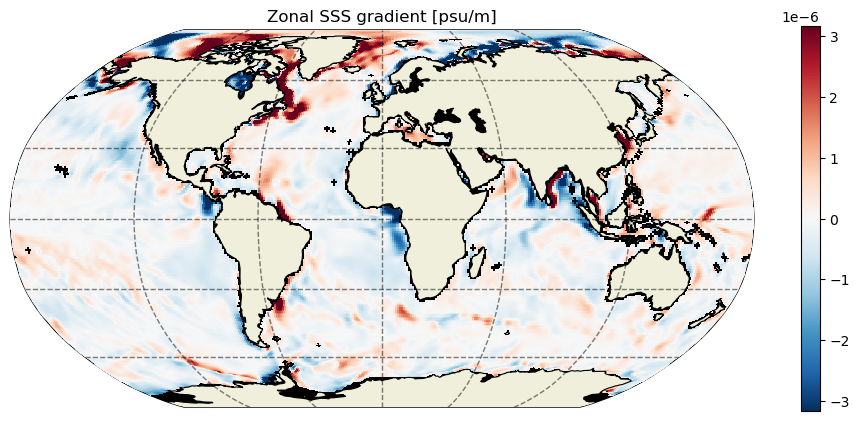

In [31]:
m=-5.5;
ecco.plot_tiles(ds_dx_hatx_G, layout='latlon', 
                rotate_to_latlon=True, cmap=colMap,
                cmin=-10**m, cmax=10**m, 
                show_tile_labels=False, show_colorbar=True,
                fig_size=8);
plt.suptitle('Zonal SSS gradient [psu/m]')
plt.show()

plt.figure(figsize=[12,5]);
ecco.plot_proj_to_latlon_grid(ds_dx_hatx_G.XC, ds_dx_hatx_G.YC, ds_dx_hatx_G,
                              cmap=colMap, cmin=-10**m, cmax=10**m, dx=.5, dy=.5, show_colorbar=True, user_lon_0=0)
plt.title('Zonal SSS gradient [psu/m]');

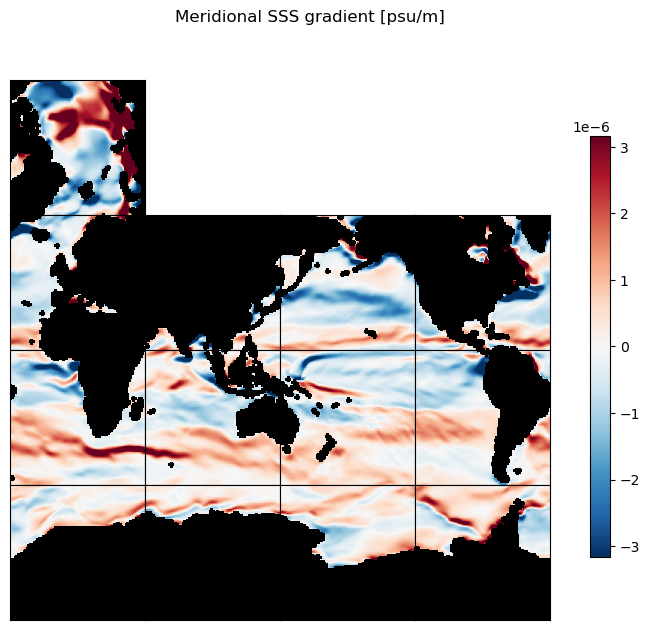

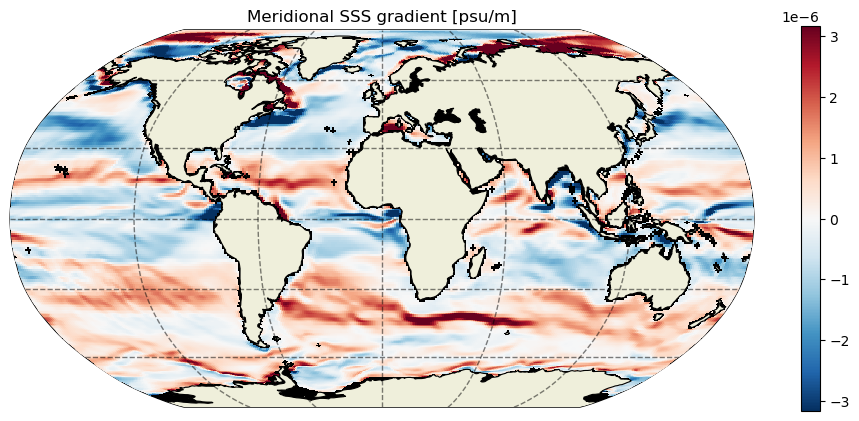

In [32]:
m=-5.5;
ecco.plot_tiles(ds_dy_haty_G, layout='latlon', 
                rotate_to_latlon=True, cmap=colMap,
                cmin=-10**m, cmax=10**m, 
                show_tile_labels=False, show_colorbar=True,
                fig_size=8);
plt.suptitle('Meridional SSS gradient [psu/m]')
plt.show()

plt.figure(figsize=[12,5]);
ecco.plot_proj_to_latlon_grid(ds_dy_haty_G.XC, ds_dy_haty_G.YC, ds_dy_haty_G,
                              cmap=colMap, cmin=-10**m, cmax=10**m, dx=.5, dy=.5, show_colorbar=True, user_lon_0=0)
plt.title('Meridional SSS gradient [psu/m]');

### 3D scalar gradients

It is no more complicated to calculate zonal and meridional gradients for 3D fields as it is for 2D fields. Below we show how to calculated zonal and meridional gradients for a 3D salinity field.

In [33]:
S3D = ecco_ds.SALT.isel(time=0).copy(deep=-True)
# set land points to nan so that we don't get big gradients between seawater (S > 0) and land (S=0)

nan_land_mask_3D = ecco_ds.maskC.where(ecco_ds.maskC > 0);

S3D = S3D*nan_land_mask_3D

In [34]:
## calculate the gradients with respect to each tile's x and y directions:

# ds/dx 
ds_dx_hatx_M_3D = XGCM_grid.diff(S3D, 'X') / ecco_ds.dxC

# ds/dy
ds_dy_haty_M_3D = XGCM_grid.diff(S3D, 'Y') / ecco_ds.dyC

grad_S_vec_to_cell_center = XGCM_grid.interp_2d_vector({'X': ds_dx_hatx_M_3D, 'Y': ds_dy_haty_M_3D},boundary='fill')

# Add the zonal components of the 'X' and 'Y' vectors
ds_dx_hatx_G_3D  = grad_S_vec_to_cell_center['X']*ecco_ds['CS'] -\
                   grad_S_vec_to_cell_center['Y']*ecco_ds['SN']

# Add the meridional components 
ds_dy_haty_G_3D  = grad_S_vec_to_cell_center['X']*ecco_ds['SN'] +\
                   grad_S_vec_to_cell_center['Y']*ecco_ds['CS']

In [35]:
# update the variable names
ds_dx_hatx_G_3D.name = 'ds_dx_hatx_G'
ds_dy_haty_G_3D.name = 'ds_dy_haty_G'

ds_dx_hatx_G_3D.attrs.update({'long_name':'zonal gradient of Salinity'})
ds_dy_haty_G_3D.attrs.update({'long_name':'meridional gradient of Salinity'})

#The gradients have units psu/m
ds_dx_hatx_G_3D.attrs.update({'units':'psu m-1'})
ds_dy_haty_G_3D.attrs.update({'units':'psu m-1'})

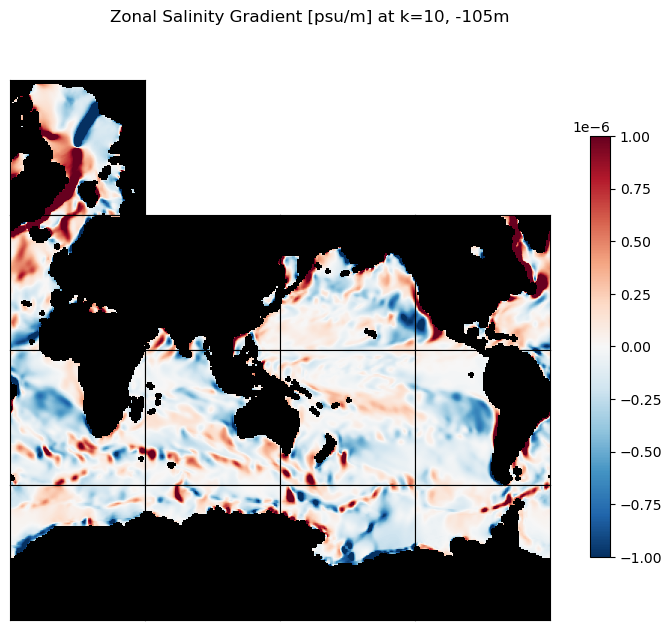

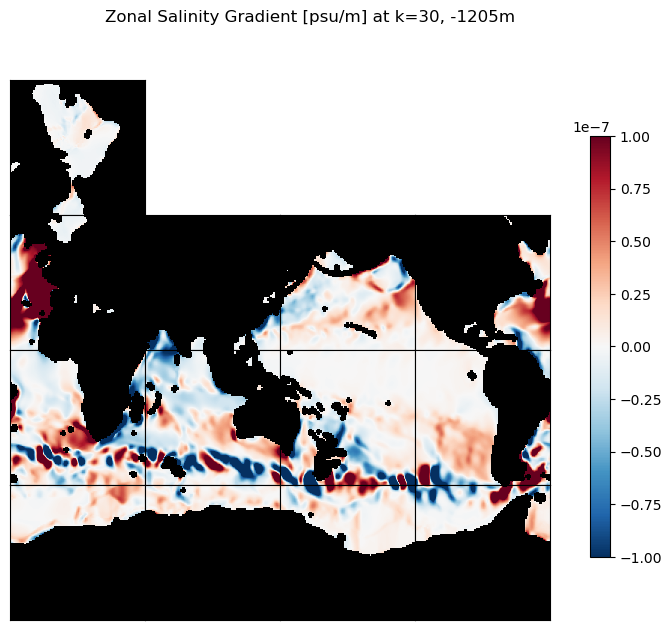

In [36]:
# plot the zonal S gradients at k=10 and k=30
m=-6;
title=f'Zonal Salinity Gradient [psu/m] at k=10, {int(ecco_ds.Z[10].values)}m';

ecco.plot_tiles(ds_dx_hatx_G_3D.isel(k=10), layout='latlon', rotate_to_latlon=True,
                cmin=-10**m, cmax=10**m, cmap=colMap,
                show_colorbar=True,
                show_tile_labels=False, fig_size=8);
plt.suptitle(title)
plt.show()

m=-7;
title=f'Zonal Salinity Gradient [psu/m] at k=30, {int(ecco_ds.Z[30].values)}m';
ecco.plot_tiles(ds_dx_hatx_G_3D.isel(k=30), layout='latlon', rotate_to_latlon=True,
                cmin=-10**m, cmax=10**m, cmap=colMap,
                show_colorbar=True,
                show_tile_labels=False, fig_size=8);
plt.suptitle(title)
plt.show()

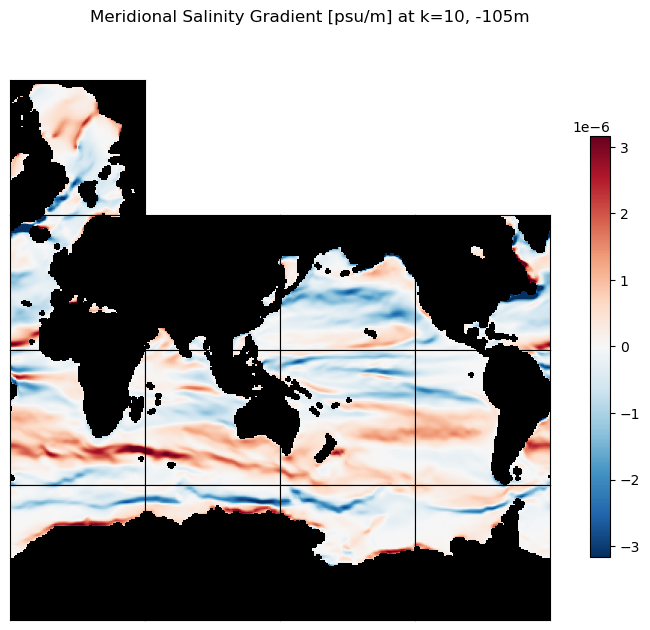

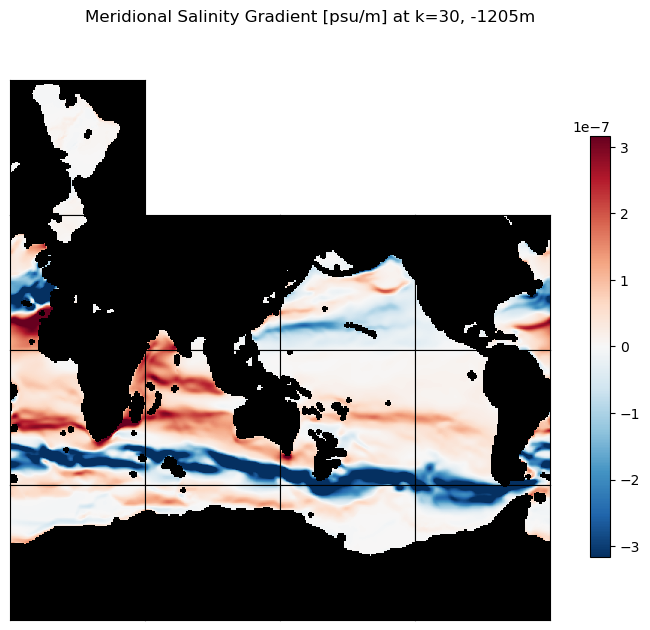

In [37]:
# plot the zonal S gradients at k=10 and k=30
m=-5.5;
title=f'Meridional Salinity Gradient [psu/m] at k=10, {int(ecco_ds.Z[10].values)}m';

ecco.plot_tiles(ds_dy_haty_G_3D.isel(k=10), layout='latlon', rotate_to_latlon=True,
                cmin=-10**m, cmax=10**m, cmap=colMap,
                show_colorbar=True,
                show_tile_labels=False, fig_size=8);
plt.suptitle(title)
plt.show()

m=-6.5;
title=f'Meridional Salinity Gradient [psu/m] at k=30, {int(ecco_ds.Z[30].values)}m';
ecco.plot_tiles(ds_dy_haty_G_3D.isel(k=30), layout='latlon', rotate_to_latlon=True,
                cmin=-10**m, cmax=10**m, cmap=colMap,
                show_colorbar=True,
                show_tile_labels=False, fig_size=8);
plt.suptitle(title)
plt.show()

### Mapping gradients to a regular lat-lon grid

Our new gradients are on the llc grid. If we want to plot them on a lat-lon grid, we can use *plot_proj_to_latlon_grid* from the *ecco_v4_py* package like we did earlier. But if you want to customize the appearance of your map more, or just want to have re-gridded lat/lon arrays in your workspace, you can use *resample_to_latlon* instead. This function does the re-gridding, and then you can use the *cartopy* package to produce maps in a variety of projections. (This is what the *plot_proj_to_latlon_grid* function is doing, just under the hood.)

In [38]:
# desired lat-lon grid spacing in the longitude and latitude directions (degrees)
new_grid_delta_lon=0.5
new_grid_delta_lat=0.5

# latitude and longitude limits of the desired lat-lon grid
new_grid_min_lat = -90; new_grid_max_lat = 90;
new_grid_min_lon = -180; new_grid_max_lon = 180;


Below we use *resample_to_latlon* to plot a global map of the zonal gradient of surface salinity $\partial{S}/\partial{\hat{x}_G}$:

In [39]:
wet_points = np.where(np.isfinite(ds_dx_hatx_G.values.ravel()))[0]
len(wet_points)

56925

In [40]:
new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges, \
grad_s_E_zonal_component_latlon = ecco.resample_to_latlon(ecco_ds.XC.values.ravel()[wet_points],
                                                          ecco_ds.YC.values.ravel()[wet_points],
                                                          ds_dx_hatx_G.values.ravel()[wet_points],
                                                     new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat, 
                                                     new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
                                                     mapping_method='bin_average',radius_of_influence=111177*1.5)

Map the wet/dry mask to lat/lon grid and use it to fill in land areas with NaNs:

In [41]:
new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges, \
land_mask_latlon = ecco.resample_to_latlon(ecco_ds.XC, ecco_ds.YC, np.where(ecco_ds.maskC.isel(k=0)==True,1,0),
                                                     new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat, 
                                                     new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,
                                                     mapping_method='nearest_neighbor',radius_of_influence=111177*1.5)
land_mask_latlon = np.where(land_mask_latlon==0, np.nan, land_mask_latlon)

In [42]:
# add time dimension
grad_s_E_zonal_component_latlon=land_mask_latlon*grad_s_E_zonal_component_latlon
grad_s_E_zonal_component_latlon=np.expand_dims(grad_s_E_zonal_component_latlon, axis=0)


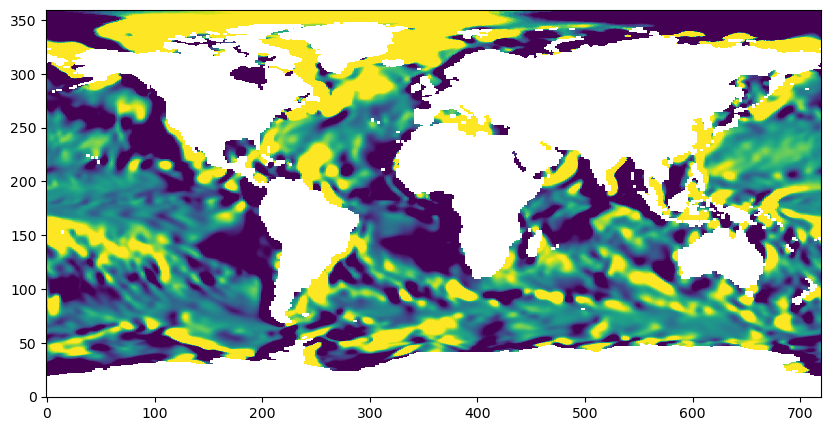

In [43]:
plt.figure(figsize=[10,10]);
plt.imshow(grad_s_E_zonal_component_latlon[0], vmin=-10**m, vmax=10**m, origin='lower', interpolation=None)
plt.show()

Create an *xarray* DataArray of the salinity zonal gradient that can be saved to a NetCDF file:

In [44]:
coords={
        "lon": new_grid_lon_centers[0,:],
        "lat": new_grid_lat_centers[:,0],
        "time": ecco_ds.time[[0]]}
#        "reference_time": pd.Timestamp("2014-09-05"),


In [45]:
grad_s_E_zonal_component_latlon_DA = xr.DataArray(grad_s_E_zonal_component_latlon,
                                             dims=['time','lat','lon'],
                                             coords=coords)
grad_s_E_zonal_component_latlon_DA.name = 'Zonal Gradient of SSS'
grad_s_E_zonal_component_latlon_DA.attrs.update({'units':'psu/m'})
print(grad_s_E_zonal_component_latlon_DA)

<xarray.DataArray 'Zonal Gradient of SSS' (time: 1, lat: 360, lon: 720)> Size: 2MB
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-4.12898265e-07, -4.12898265e-07, -4.12898265e-07, ...,
         -4.12898265e-07, -4.12898265e-07, -4.12898265e-07],
        [-4.66182148e-07, -4.66182148e-07, -4.66182148e-07, ...,
         -4.66182148e-07, -4.66182148e-07, -4.66182148e-07],
        [-1.32423822e-07, -1.32423822e-07, -1.32423822e-07, ...,
         -1.32423822e-07, -1.32423822e-07, -1.32423822e-07]]])
Coordinates:
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 

In [46]:
filename = f'SSS_zonal_gradient_{str(grad_s_E_zonal_component_latlon_DA.time.values)[2:12]}.nc'
print(filename)

SSS_zonal_gradient_2000-01-16.nc


In [47]:
grad_s_E_zonal_component_latlon_DA.to_netcdf(f'~/{filename}')
grad_s_E_zonal_component_latlon_DA.close()

Plot a nicer-looking map of the SSS zonal gradient using the *cartopy* package, in the Robinson map projection:

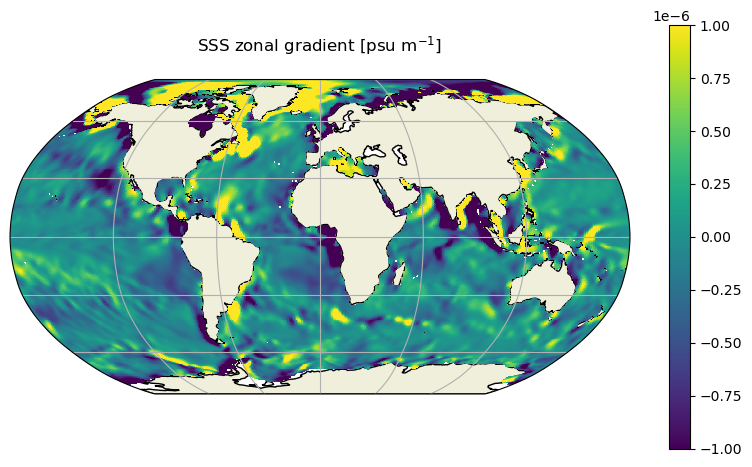

In [48]:
m=-6;
f,ax = plt.subplots(1,1,figsize=[10,5.5], 
                    subplot_kw={'projection': ccrs.Robinson()})

vector_crs=ccrs.PlateCarree()

h=ax.pcolormesh(new_grid_lon_centers, new_grid_lat_centers, 
                grad_s_E_zonal_component_latlon_DA.isel(time=0), transform=vector_crs,\
                vmin=-10**m, vmax=10**m )

ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')  # mask land areas, with black border for the coastlines
ax.set_global()
ax.gridlines()

f.colorbar(h, orientation='vertical');
ax.set_title('SSS zonal gradient [psu m$^{-1}$]\n',fontsize=12);

## Calculating gradients of vector fields located on the 'u' and 'v' points (vorticity/divergence)

The ECCO model uses the Arakawa-C grid where velocities and horizontal fluxes are located at the grid cell edges (i.e., the 'u' and 'v' points), unlike scalar fields which are located at the grid cell centers (tracer points).

Gradients of vector fields located at 'u' and 'v' points are themselves located at tracer points, "halfway" between adjacent grid cell edges. The meridional and zonal gradients of vector fields, e.g., horizontal ocean velocity, yield four gradient components:

1. Zonal gradient of the **zonal component** of the vector ($\partial{u_\lambda}/\partial{\lambda}$)

1. Zonal gradient of the **meridional component** of the vector ($\partial{v_\phi}/\partial{\lambda}$)

1. Meridional gradient of the **meridional component** of the vector ($\partial{v_\phi}/\partial{\phi}$)

1. Meridional gradient of the **zonal component**  of the vector ($\partial{u_\lambda}/\partial{\phi}$)

Two of these gradients $\partial{v_\phi}/\partial{\lambda} - \partial{u_\lambda}/\partial{\phi}$ comprise the vorticity or curl of the flow field, while the other two $\partial{u_\lambda}/\partial{\lambda} + \partial{v_\phi}/\partial{\phi}$ comprise the horizontal divergence of the flow field.


The recipe is as follows:

1. interpolate the 'x' and 'y' components of the flow field, u_x and v_y respectively, to the grid cell centers

1. rotate the u_x and v_y vectors from the orthogonal 'x-y' basis to the orthogonal *lambda-phi* basis, the basis of parallels and meridians to make the u_lambda and v_phi vectors.

1. calculate the gradients of 'u_lambda' and 'v_phi' with respect to the model's 'x' direction to make *du_lambda_dx* and *dv_phi_dx* vectors

1. calculate the gradients of 'u_lambda' and 'v_phi' with respect to the model's 'y' direction to make *du_lambda_dy* and *dv_phi_dy* vectors

1. interpolate the four gradients to the tracer points

1. rotate the four gradients of the zonal flow with respect to 'x' and 'y' to the zonal and meridional directions to make the *du_lambda_dphi* and *du_lambda_dlambda* vectors

1. rotate the gradients of the meridional flow with respect to 'x' and 'y' to the zonal and meridional directions to make the *dv_phi_dphi* and *dv_phi_dlambda* vectors


Note: for vorticity calculations we could use 1) *dv_phi_dlambda* and *du_lambda_dphi* or 2) *dv_y_dx* and *du_x_dy*. Vorticity calculated using *dv_phi_dlambda* and *du_lambda_dphi* is calculated at tracer points while vorticity calculated using *dv_y_dx* and *du_x_dy* are calculated at the so-called zeta points (the grid cell corners of tracer cells). Vorticity calculated at zeta points may be more accurate than those calculated at tracer points because fewer interpolations are required. The calculation of vorticity on the zeta points is the subject of a different tutorial.

### Preliminaries: Load fields

In [49]:
## Load ocean velocities

## Merge the ecco_grid with the velocity ecco_vars to make the ecco_ds
ecco_ds = xr.merge((ecco_grid , ecco_vars_vel)).compute()

# the dataset contains uvel, vvel, and wvel
print(list(ecco_vars_vel.data_vars))

['UVEL', 'VVEL', 'WVEL']


### Pull out the 'x' and 'y' components of the vector field

The ECCO llc horizontal ocean velocity vector is composed of two components: 'UVEL' is the component along each tile's 'x' axis and 'VVEL' is the component along each tile's 'y' axis. Following the convention of the Arakawa-C grid, UVEL and VVEL are staggered in space between tracer cell centers. 'UVEL' is located on 'u' points ```[i_g, j]``` while 'VVEL' is located on the 'v' points ```[i, j_g]```. 

We designate 'u_x' as the component of the full ocean velocity vector aligned with 'x' axis and 'v_y' as the component aligned with the 'y' axis. To make the calculation faster we'll calculate the gradients for the top ocean grid cell (k=0).

In [50]:
u_x = ecco_ds.UVEL.isel(time=0, k=0).copy(deep=True)
v_y = ecco_ds.VVEL.isel(time=0, k=0).copy(deep=True)

# set land points to nan so that we don't get big gradients between ocean and land
# ... the wet/dry mask for 'u' points is in the 'maskW' field
# ... the wet/dry mask for 'v' points is in the 'maskS' field
nan_land_mask_W = ecco_ds.maskW.where(ecco_ds.maskW.isel(k=0) > 0);
nan_land_mask_S = ecco_ds.maskS.where(ecco_ds.maskS.isel(k=0) > 0);

# mask land points with nan
u_x = u_x*nan_land_mask_W.isel(k=0)
v_y = v_y*nan_land_mask_S.isel(k=0)

# confirm that the field is indeed in the native grid format and tracer cell point [dimensions 'tile','i','j']
# (13 tiles of 90x90)
print(f'\nuvel dimensions:  {u_x.dims}')
print(f'uvel shape:       {u_x.shape}')
print(f'\nvvel dimensions: {v_y.dims}')
print(f'vvel shape:       {v_y.shape}')


uvel dimensions:  ('tile', 'j', 'i_g')
uvel shape:       (13, 90, 90)

vvel dimensions: ('tile', 'j_g', 'i')
vvel shape:       (13, 90, 90)


### Plot the 'x' and 'y' components of the vector field

As you can readily see in the following plots, the 'x' component of the ocean velocity (ux) looks roughly zonal in tiles 0-5 and roughly -1 * meridional in tiles 7-9. Similarly, the 'y' component of ocean velocity (vy) looks roughly meridional in tiles 0-5, and roughly zonal in tiles 7-9. 

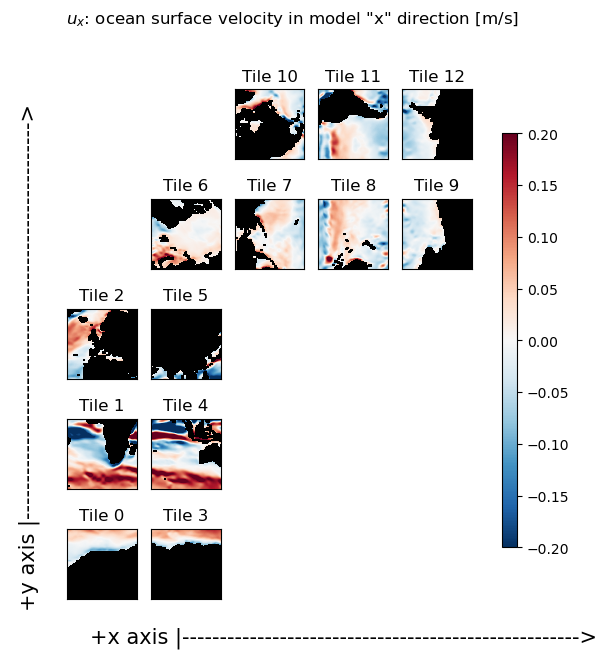

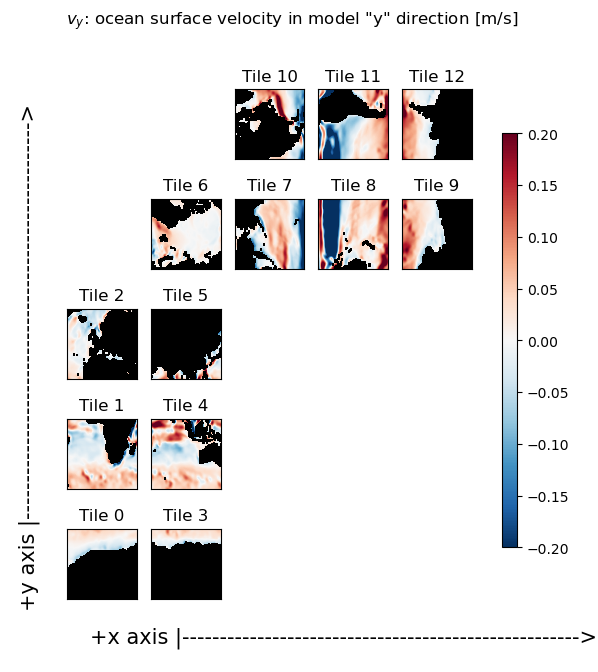

In [51]:
m=.2;
X = ecco.plot_tiles(u_x, show_tile_labels=True,fig_size=6, 
                    show_colorbar=True, cmin=-m,cmax=m, cmap=colMap);
fig=X[0]
fig.suptitle(f'$u_x$: ocean surface velocity in model "x" direction [m/s]')
ax=fig.get_axes()[-1]
ax.annotate('+x axis |----------------------------------------------------->',
            xy=(.15, .065), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top', fontsize=15);
ax.annotate('+y axis |----------------------------------------------------->',
            xy=(0.03, .825), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',rotation=90, fontsize=15);
# plt.figure();

X = ecco.plot_tiles(v_y, show_tile_labels=True,fig_size=6, 
                    show_colorbar=True, cmin=-m,cmax=m, cmap=colMap);
fig=X[0]
fig.suptitle(f'$v_y$: ocean surface velocity in model "y" direction [m/s]')
ax=fig.get_axes()[-1]
ax.annotate('+x axis |----------------------------------------------------->',
            xy=(.15, .065), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top', fontsize=15);
ax.annotate('+y axis |----------------------------------------------------->',
            xy=(0.03, .825), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',rotation=90, fontsize=15);

### Part 1: calculate the zonal and meridional components of the flow field from ux and vy

In [52]:
## calculate the zonal and meridional components of flow from the u_x and v_y components

# u_x and v_y are located at the model's 'u' and 'v' points, respectively.
# interpolate the vectors to the cell centers at i,j
vec_u_to_ij = XGCM_grid.interp_2d_vector({'X': u_x, 'Y': v_y},boundary='fill')

# vec_u_to_ij is a dictionary holding the interpolated vectors with the 'X' and 'Y' keys.

# rotate the interpolated vectors to the zonal (lambda) and meridional (phi) basis
# Add the zonal components of the 'X' and 'Y' vectors
u_lambda       = vec_u_to_ij['X']*ecco_ds['CS'] - vec_u_to_ij['Y']*ecco_ds['SN']

# Add the meridional components 
v_phi          = vec_u_to_ij['X']*ecco_ds['SN'] + vec_u_to_ij['Y']*ecco_ds['CS']

In [53]:
# confirm that the zonal and meridional components of the flow are at the tracer cell points [dimensions 'tile','i','j'] (13 tiles of 90x90)
print(f'\nu_lambda dimensions  : {u_lambda.dims}')
print(f'u_lambda shape       : {u_lambda.shape}')
print(f'\nv_phi dims   : {v_phi.dims}')
print(f'v_phi shape  : {v_phi.shape}')


u_lambda dimensions  : ('tile', 'j', 'i')
u_lambda shape       : (13, 90, 90)

v_phi dims   : ('tile', 'j', 'i')
v_phi shape  : (13, 90, 90)


Confirm that the vector interpolation to cell centers and rotation looks like zonal and meridional flow, not flow along the model's 'x' and 'y' axes.

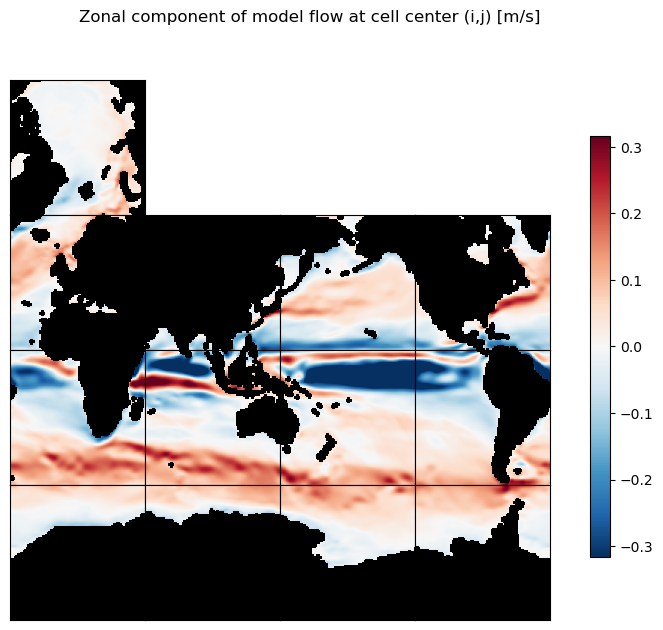

In [54]:
# Plot the zonal component of flow as 13 tiles

m=-.5;
ecco.plot_tiles(u_lambda, layout='latlon', rotate_to_latlon=True, show_tile_labels=False, 
                cmin=-10**m, cmax=10**m, cmap=colMap, fig_size=8, 
                show_colorbar=True);
plt.suptitle('Zonal component of model flow at cell center (i,j) [m/s]')
plt.show()

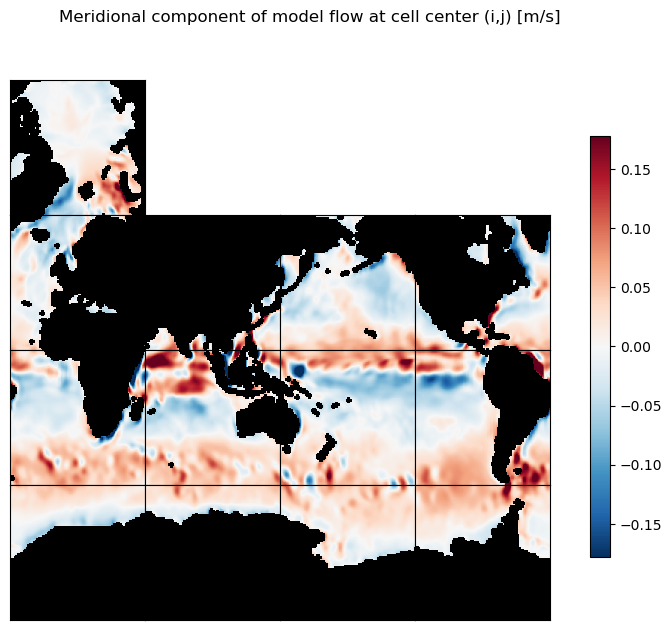

In [55]:
# Plot the meridional component of flow as 13 tiles
m=-0.75
ecco.plot_tiles(v_phi, layout='latlon', rotate_to_latlon=True, show_tile_labels=False, 
                 cmin=-10**m, cmax=10**m, cmap=colMap, fig_size=8, show_colorbar=True)  ;
plt.suptitle('Meridional component of model flow at cell center (i,j) [m/s]')
plt.show()

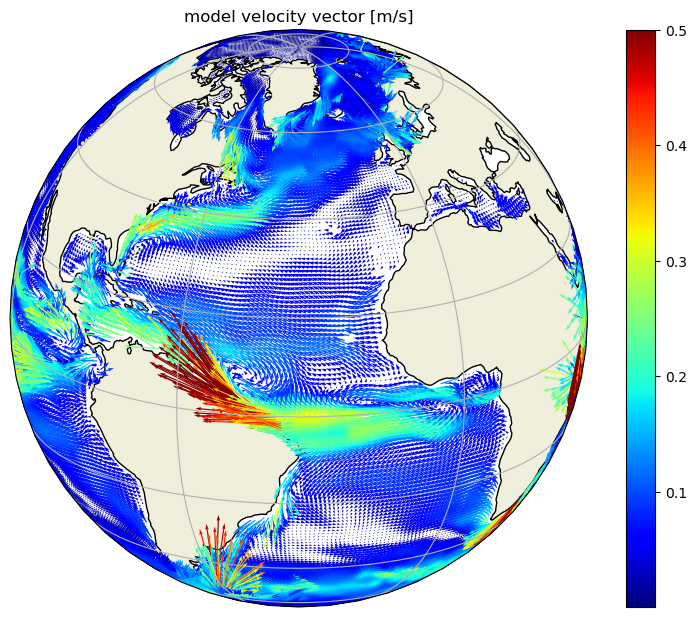

In [56]:
# Plot the two components together as quiver on globe
f,ax = plt.subplots(1,1,figsize=[10,7.5], 
                    subplot_kw={'projection': ccrs.Orthographic(-35, 20)})

vector_crs=ccrs.PlateCarree()

c = np.sqrt(u_lambda**2 + v_phi**2)
c = np.where(~np.isfinite(c), 0, c);
c = np.where(c>.5, .5, c);

h=ax.quiver(ecco_ds.XC.values.ravel(),
            ecco_ds.YC.values.ravel(),
            u_lambda.values.ravel(), 
            v_phi.values.ravel(), 
            c.ravel(), scale=4 , 
            transform=vector_crs, width=0.002, cmap='jet',headwidth=3)

ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax.set_global()
ax.gridlines()

f.colorbar(h, orientation='vertical');
ax.set_title('model velocity vector [m/s]',fontsize=12);

### Part 2: calculate the zonal and meridional gradients of the *zonal* and *meridional* flow fields

#### Zonal and meridional gradients of *zonal* flow field

We begin by calculating the gradients of zonal flow field with respect to the model's 'x' and 'y' directions. The gradients in 'x' will be at the model's 'u' points while the gradients in 'y' will be at the model's 'v' points.

In [57]:
# calculate the gradient in the model 'x' direction
du_lambda_dx = XGCM_grid.diff(u_lambda, 'X') / ecco_ds.dxC

# calculate the gradient in the model 'y' direction
du_lambda_dy = XGCM_grid.diff(u_lambda, 'Y') / ecco_ds.dyC

We confirm that the gradient of zonal flow with respect to the model 'x' direction is at model 'u' points: ```[i_g, j]``` and that the gradient with respect to the model 'y' direction is at model 'v' points: ```[i, j_g]```

In [58]:
print(f'du_lambda_dx dims: {du_lambda_dx.dims}')
print(f'du_lambda_dx shape: {du_lambda_dx.shape}')

print(f'\ndu_lambda_dy dims: {du_lambda_dy.dims}')
print(f'du_lambda_dy shape: {du_lambda_dy.shape}')

du_lambda_dx dims: ('tile', 'j', 'i_g')
du_lambda_dx shape: (13, 90, 90)

du_lambda_dy dims: ('tile', 'j_g', 'i')
du_lambda_dy shape: (13, 90, 90)


We now interpolate the 'x' and 'y' gradients of the zonal flow field from the 'u' and 'v' points, respectively to the tracer points.

In [59]:
# interpolate the gradients from cell boundaries to the cell centers
# the 'grad' variable is a dictionary with the 'x' and 'y' components interpolated to the i,j points
grad_u_lambda_to_ij = XGCM_grid.interp_2d_vector({'X': du_lambda_dx, 'Y': du_lambda_dy},boundary='fill')

The next step is to rotate the 'x' and 'y' components of the zonal flow field gradient to the zonal and meridional directions

In [60]:
# rotate to zonal and meridional directions
# Add the zonal components of the 'X' and 'Y' vector components
du_lambda_dlambda    = grad_u_lambda_to_ij['X']*ecco_ds['CS'] - grad_u_lambda_to_ij['Y']*ecco_ds['SN']

# Add the meridional components 
du_lambda_dphi       = grad_u_lambda_to_ij['X']*ecco_ds['SN'] + grad_u_lambda_to_ij['Y']*ecco_ds['CS']

#### Plot zonal and meridional gradients of *zonal* flow field

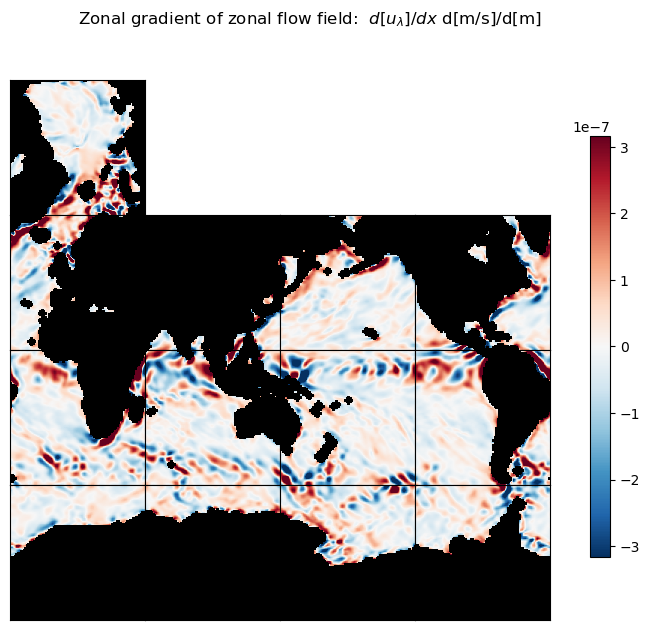

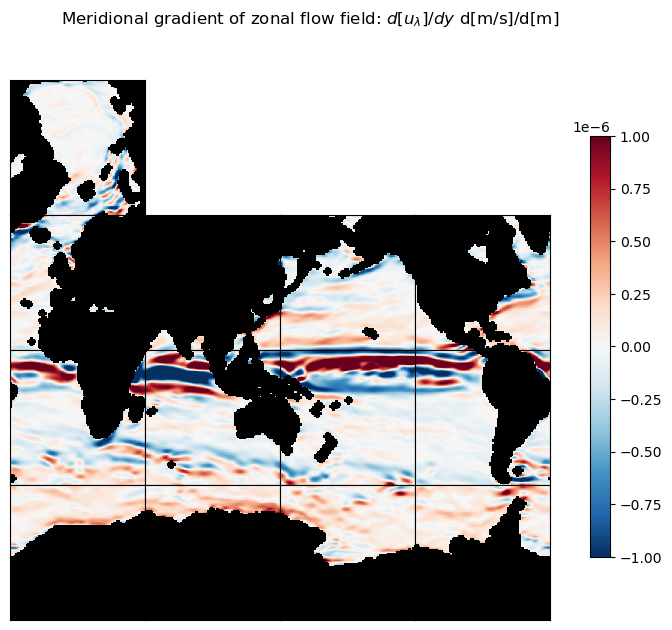

In [61]:
m=-6.5
title = 'Zonal gradient of zonal flow field:  $d[u_\lambda]/dx$ d[m/s]/d[m]'
ecco.plot_tiles(du_lambda_dlambda, layout='latlon', rotate_to_latlon=True, show_tile_labels=False, 
                cmin=-10**m, cmax=10**m, cmap=colMap, fig_size=8, show_colorbar=True);
plt.suptitle(title)
plt.show()

m=-6
title = 'Meridional gradient of zonal flow field: $d[u_\lambda]/dy$ d[m/s]/d[m]'
ecco.plot_tiles(du_lambda_dphi, layout='latlon', rotate_to_latlon=True, show_tile_labels=False, 
                cmin=-10**m, cmax=10**m, cmap=colMap, fig_size=8, show_colorbar=True);
plt.suptitle(title)
plt.show()

#### Zonal and meridional gradients of *meridional* flow field

Next calculate the gradients of meridional flow field with respect to the model's 'x' and 'y' directions. The gradients in 'x' will be at the model's 'u' points while the gradients in 'y' will be at the model's 'v' points.

#### calculate the zonal and meridional gradients of *meridional* flow

In [62]:
# calculate the gradient in the model 'x' direction
dv_phi_dx = XGCM_grid.diff(v_phi, 'X') / ecco_ds.dxC

# calculate the gradient in the model 'y' direction
dv_phi_dy = XGCM_grid.diff(v_phi, 'Y') / ecco_ds.dyC

We confirm that the gradient of meridional flow with respect to the model 'x' direction is at model 'u' points: ```[i_g, j]``` and that the gradient with respect to the model 'y' direction is at model 'v' points: ```[i, j_g]```

In [63]:
print(f'dv_phi_dx dims: {dv_phi_dx.dims}')
print(f'dv_phi_dx shape: {dv_phi_dx.shape}')

print(f'\ndv_phi_dy dims: {dv_phi_dy.dims}')
print(f'dv_phi_dy shape: {dv_phi_dy.shape}')

dv_phi_dx dims: ('tile', 'j', 'i_g')
dv_phi_dx shape: (13, 90, 90)

dv_phi_dy dims: ('tile', 'j_g', 'i')
dv_phi_dy shape: (13, 90, 90)


We now interpolate the 'x' and 'y' gradients of the zonal flow field from the 'u' and 'v' points, respectively to the tracer points.

In [64]:
# interpolate the gradients from cell boundaries to the cell centers
# the 'grad' variable is a dictionary with the 'x' and 'y' components interpolated to the i,j points
grad_v_phi_to_ij = XGCM_grid.interp_2d_vector({'X': dv_phi_dx, 'Y': dv_phi_dy},
                                              boundary='fill')

Confirm that after interpolation the X and Y components of the gradient vector are at the tracer points:

In [65]:
print('dimensions of the X and Y components of the gradient vector')
print(f'X component of the gradient vector: {grad_v_phi_to_ij["X"].dims}')
print(f'Y component of the gradient vector: {grad_v_phi_to_ij["Y"].dims}')

dimensions of the X and Y components of the gradient vector
X component of the gradient vector: ('tile', 'j', 'i')
Y component of the gradient vector: ('tile', 'j', 'i')


The final step is to rotate the 'x' and 'y' components of the meridional flow field gradient vector to the zonal and meridional directions

In [66]:
# rotate to zonal and meridional directions
# Add the zonal components of the 'X' and 'Y' vector components
dv_phi_dlambda    = grad_v_phi_to_ij['X']*ecco_ds['CS'] - grad_v_phi_to_ij['Y']*ecco_ds['SN']

# Add the meridional components 
dv_phi_dphi       = grad_v_phi_to_ij['X']*ecco_ds['SN'] + grad_v_phi_to_ij['Y']*ecco_ds['CS']

#### Plot zonal and meridional gradients of *meridional* flow field

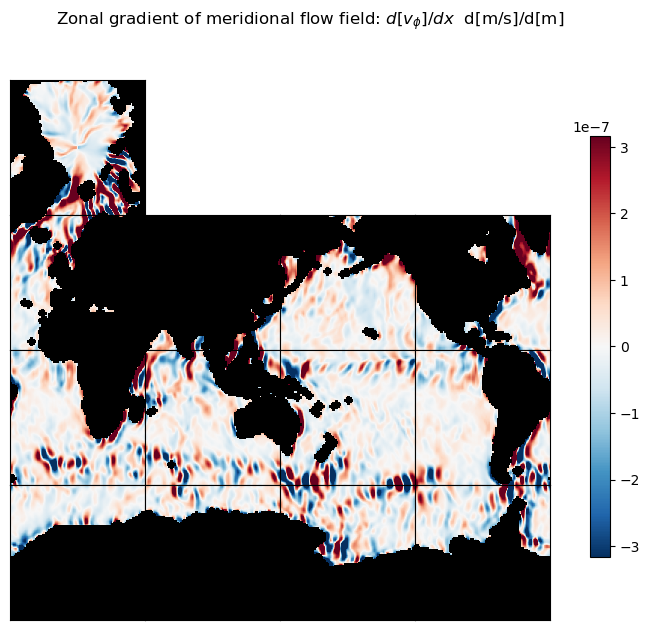

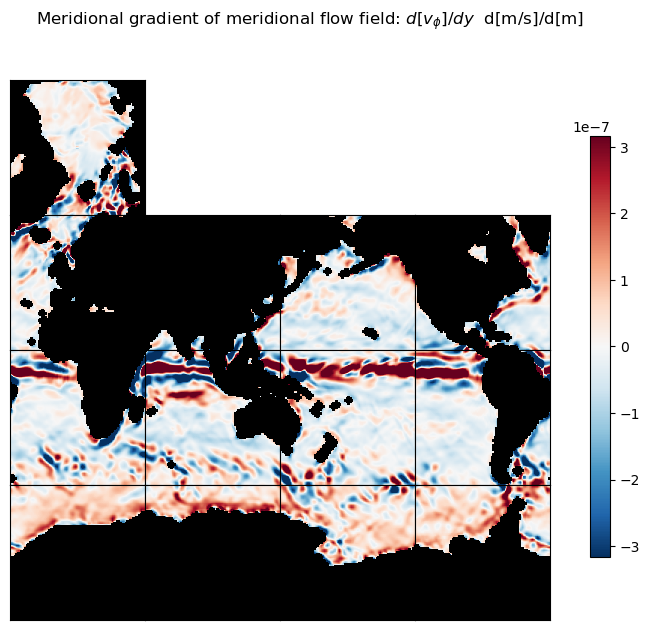

In [67]:
m=-6.5
title = 'Zonal gradient of meridional flow field: $d[v_\phi]/dx$  d[m/s]/d[m]'
ecco.plot_tiles(dv_phi_dlambda, layout='latlon', rotate_to_latlon=True, 
                show_tile_labels=False, 
                cmin=-10**m, cmax=10**m, cmap=colMap, fig_size=8, 
                show_colorbar=True);
plt.suptitle(title)
plt.show()


title = 'Meridional gradient of meridional flow field: $d[v_\phi]/dy$  d[m/s]/d[m]'
ecco.plot_tiles(dv_phi_dphi, layout='latlon', rotate_to_latlon=True, 
                show_tile_labels=False, 
                cmin=-10**m, cmax=10**m, cmap=colMap, fig_size=8, 
                show_colorbar=True);
plt.suptitle(title)
plt.show()

### Part 3: calculate relative vorticity from the flow field gradients

Let's wrap up this section by calcualting the relative vorticity: $\bf{\omega} = \nabla\times\bf{u}$

$$\omega = \frac{\partial{v}}{\partial{x}} - \frac{\partial{u}}{\partial{y}}$$

For the $\partial{v}/\partial{x}$ term use the zonal gradient of meridional velocity,
`d_v_phi_dlambda` and for the $\partial{u}/\partial{y}$ term use the meridional gradient of zonal velocity,
`d_u_lambda_dphi`.



In [68]:
omega = dv_phi_dlambda - du_lambda_dphi

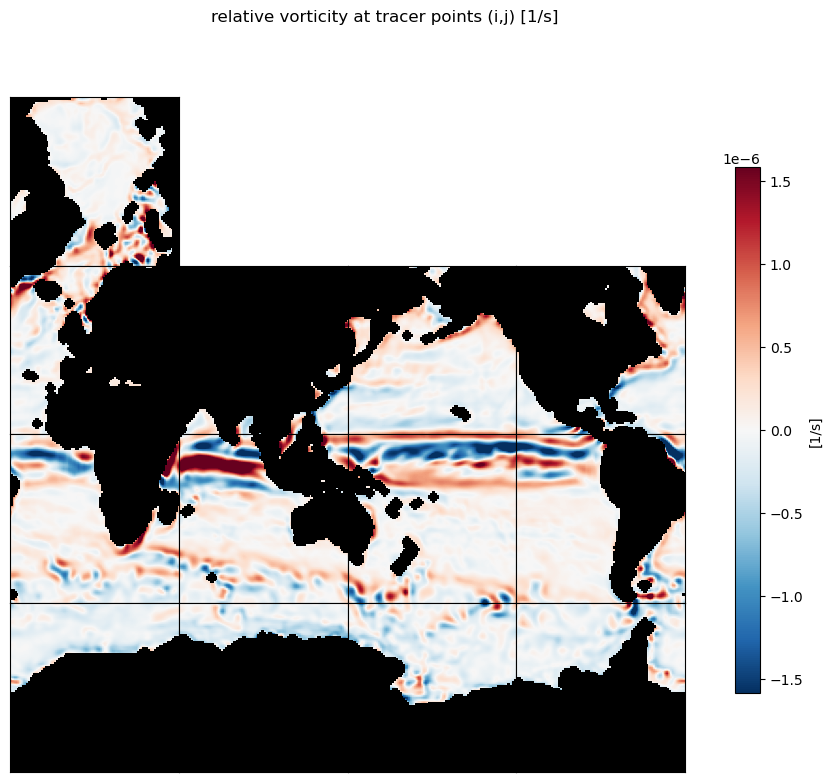

In [69]:
m=-5.8;
title='relative vorticity at tracer points (i,j) [1/s]'
ecco.plot_tiles(omega, cmin=-10**m, cmax=10**m,fig_size=10, 
                show_tile_labels=False, 
                rotate_to_latlon=True, layout='latlon',  cmap=colMap,
                show_colorbar=True, cbar_label='[1/s]', show_cbar_label=True);
plt.suptitle(title)
plt.show()

## Calculating gradients of vector fields located on the grid cell centers (wind/surface stress curl)

In ECCO llc state estimates the atmosphere forcing vector fields (surface winds/wind stress) are located at the grid cell centers (i.e., the tracer points). It is important to note that, in contrast, horizontal vector fields generated by the model like horizontal velocity (UVEL,VVEL) and horizontal advective and diffusive fluxes are located at the grid cell edges ('u' and 'v' points). 

The meridional and zonal gradients of these vector fields yield four gradient components:

1. Zonal gradient of the **zonal component** of the vector

1. Zonal gradient of the **meridional component** of the vector

1. Meridional gradient of the **meridional component** of the vector

1. Meridional gradient of the **zonal component**  of the vector



The recipe is as follows. It is the same as the recipe for the vector fields located on grid cell edges, except with the first interpolation step omitted:

1. rotate the u_x and v_y vectors from the orthogonal 'x-y' basis to the orthogonal *lambda-phi* basis, the basis of parallels and meridians to make the u_lambda and v_phi vectors.

1. calculate the gradients of 'u_lambda' and 'v_phi' with respect to the model's 'x' direction to make *du_lambda_dx* and *dv_phi_dx* vectors

1. calculate the gradients of 'u_lambda' and 'v_phi' with respect to the model's 'y' direction to make *du_lambda_dy* and *dv_phi_dy* vectors

1. interpolate the four gradients to the tracer points

1. rotate the four gradients of the zonal flow with respect to 'x' and 'y' to the zonal and meridional directions to make the *du_lambda_dphi* and *du_lambda_dlambda* vectors

1. rotate the gradients of the meridional flow with respect to 'x' and 'y' to the zonal and meridional directions to make the *dv_phi_dphi* and *dv_phi_dlambda* vectors


### Preliminaries: Load fields

In [70]:
## Load monthly surface atmospheric conditions from 2000

## Merge the ecco_grid with the surface atmosphere ecco_vars to make the ecco_ds
ecco_ds = xr.merge((ecco_grid,ecco_vars_atm)).compute()

### Pull out the 'x' and 'y' components of the vector field

ECCO v4 atmosphere wind vectors are provided as two fields, one for the component along each tile's 'x' axis and the other for the component along each tile's 'y' axis.

We will designate 'u_x' as the wind vector component along each tile;s 'x' axis and 'v_y' as the wind vector copmonent along each tile's 'y' axis.

#### Plot the 'x' and 'y' components of the vector field

As you can readily see in the following plots, the 'x' component of the wind field (u_x) looks roughly zonal in tiles 0-5, while it looks roughly -1 * meridional in tiles 7-9. Similarly, the 'y' component of the wind field (v_y) looks roughly meridional in tiles 0-5, and roughly zonal in tiles 7-9. So the next step is to rotate the vector defined by these u_x and v_y components into the zonal and meridional directions.


In [71]:
u_x = ecco_ds.EXFuwind.isel(time=0).copy(deep=True)
v_y = ecco_ds.EXFvwind.isel(time=0).copy(deep=True)

# set land points to nan so that we don't get big gradients between seawater (S > 0) and land (S=0)
nan_land_mask = ecco_ds.maskC.where(ecco_ds.maskC.isel(k=0) > 0);

# mask land points with nan
u_x = u_x*nan_land_mask.isel(k=0)
v_y = v_y*nan_land_mask.isel(k=0)

print(f'u wind field time: {u_x.time.values}')
print(f'v wind field time: {v_y.time.values}')

# confirm that the field is indeed in the native grid format and tracer cell point [dimensions 'tile','i','j'] (13 tiles of 90x90)
print(f'\nu wind dimensions: {u_x.dims}')
print(f'u wind shape: {u_x.shape}')
print(f'\nv wind dimensions: {v_y.dims}')
print(f'v wind shape: {v_y.shape}')

u wind field time: 2000-01-16T12:00:00.000000000
v wind field time: 2000-01-16T12:00:00.000000000

u wind dimensions: ('tile', 'j', 'i')
u wind shape: (13, 90, 90)

v wind dimensions: ('tile', 'j', 'i')
v wind shape: (13, 90, 90)


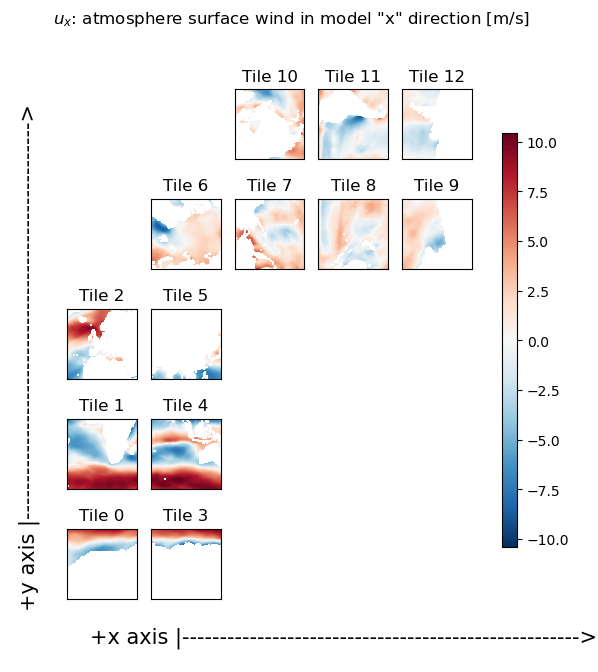

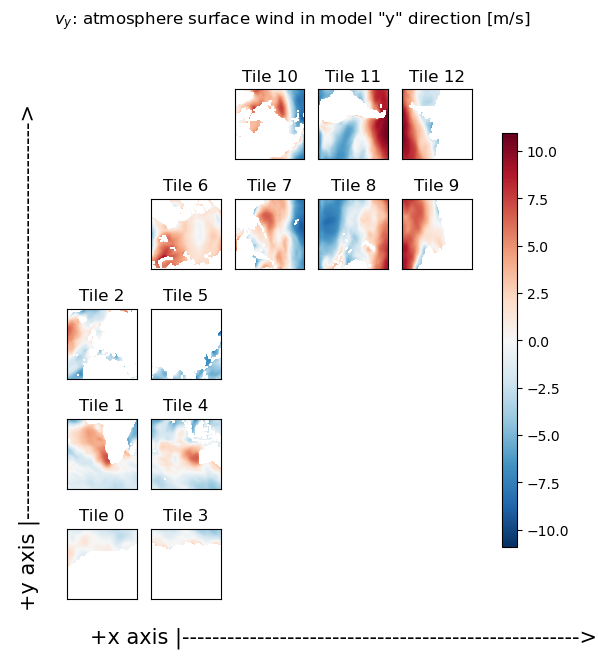

In [72]:
title='$u_x$: atmosphere surface wind in model "x" direction [m/s]'
X = ecco.plot_tiles(u_x, show_tile_labels=True,fig_size=6, show_colorbar=True);
fig=X[0]
fig.suptitle(title)
ax = fig.get_axes()[-1]
ax.annotate('+x axis |----------------------------------------------------->',
            xy=(.15, .065), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top', fontsize=15);
ax.annotate('+y axis |----------------------------------------------------->',
            xy=(0.03, .825), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',rotation=90, fontsize=15);


title='$v_y$: atmosphere surface wind in model "y" direction [m/s]'
X = ecco.plot_tiles(v_y, show_tile_labels=True,fig_size=6, show_colorbar=True);
fig=X[0]
fig.suptitle(title)
ax = fig.get_axes()[-1]
ax.annotate('+x axis |----------------------------------------------------->',
            xy=(.15, .065), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top', fontsize=15);
ax.annotate('+y axis |----------------------------------------------------->',
            xy=(0.03, .825), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',rotation=90, fontsize=15);

### Rotate the 'x' and 'y' components to the zonal and meridional directions

The next step is to rotate these two wind vector components so that the two vector fields align with parallels and meridians (true zonal and meridional directions)


In [73]:
# Add the zonal components of the 'X' and 'Y' components of the original vectors
u_lambda       = u_x*ecco_grid['CS'] - v_y*ecco_grid['SN']

# Add the meridional components of the 'X' and 'Y' component of the original vectors
v_phi          = u_x*ecco_grid['SN'] + v_y*ecco_grid['CS']

### Plot zonal and meridional wind field


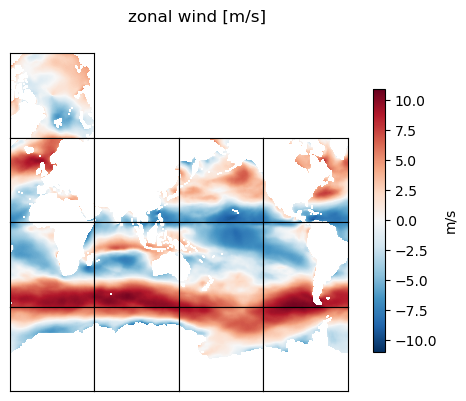

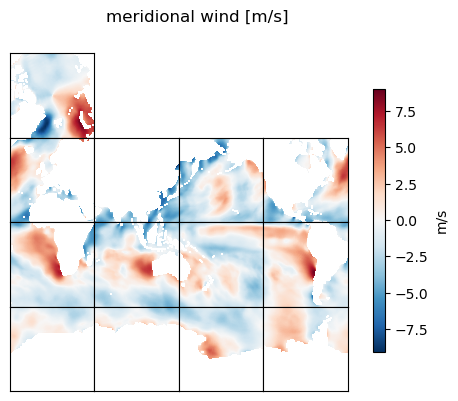

In [74]:
title = 'zonal wind [m/s]'
ecco.plot_tiles(u_lambda, rotate_to_latlon=True, layout='latlon', 
                show_tile_labels=False, show_colorbar=True,cbar_label='m/s', show_cbar_label=True, fig_size=5);
plt.suptitle(title)
plt.show()

title='meridional wind [m/s]'
ecco.plot_tiles(v_phi, rotate_to_latlon=True, layout='latlon', 
                show_tile_labels=False, show_colorbar=True,cbar_label='m/s', show_cbar_label=True, fig_size=5);
plt.suptitle(title)
plt.show()

### Calculate the zonal and meridional gradients of the *zonal* wind field

Now that we have the zonal and meridional components of the wind vector separated out, we can can calculate their zonal and meridional gradients.

#### Zonal and meridional gradients of zonal wind

In [75]:
## calculate the zonal and meridional gradients of zonal wind

# zonal wind is u_lambda

# first gradients in the directions adjacent model grid cells
# 'x' direction: du_lambda_dx
du_lambda_dx = XGCM_grid.diff(u_lambda, 'X') / ecco_ds.dxC

# 'y' direction
# duE/dx 
du_lambda_dy = XGCM_grid.diff(u_lambda, 'Y') / ecco_ds.dyC

# gradients are at the cell boundaries 
# interpolate the gradients to the cell centers
grad_u_lambda_to_ij = XGCM_grid.interp_2d_vector({'X': du_lambda_dx, 'Y': du_lambda_dy},boundary='fill')

# rotate to zonal and meridional directions
# Add the zonal components of the 'X' and 'Y' vectors
du_lambda_dlambda       = grad_u_lambda_to_ij['X']*ecco_ds['CS'] - grad_u_lambda_to_ij['Y']*ecco_ds['SN']

# Add the meridional components 
du_lambda_dphi          = grad_u_lambda_to_ij['X']*ecco_ds['SN'] + grad_u_lambda_to_ij['Y']*ecco_ds['CS']

#### Plot zonal and meridional gradients of *zonal* wind

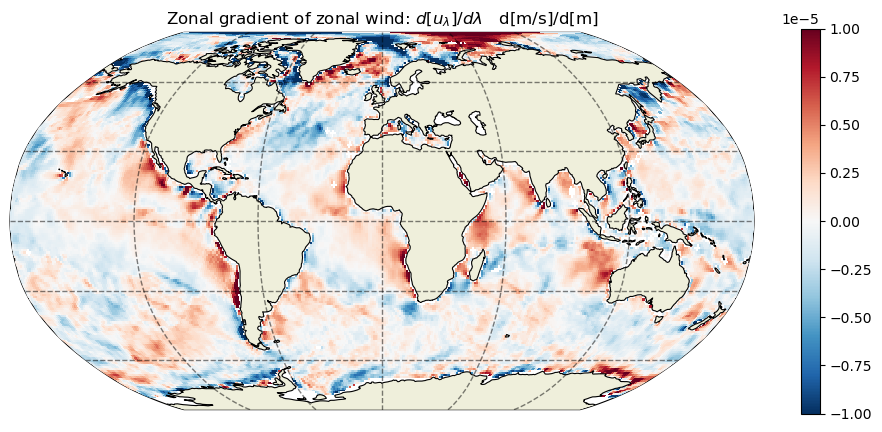

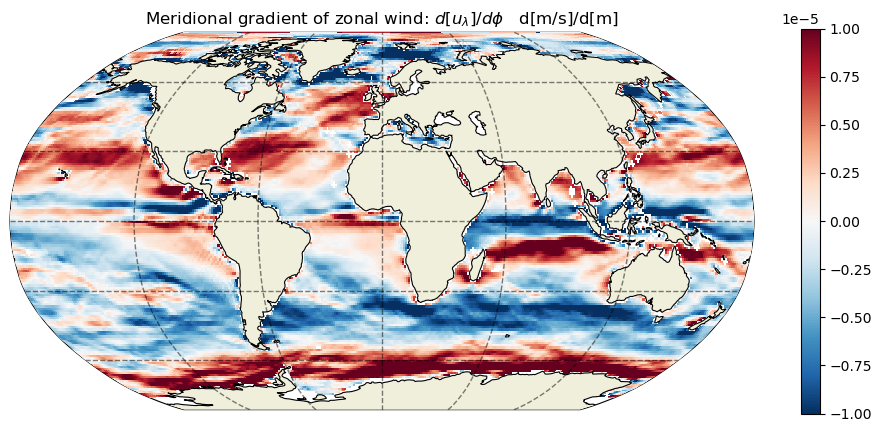

In [76]:
plt.figure(figsize=[12,5]);
m=-5
dx=1
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, du_lambda_dlambda,
                                  cmin=-10**m, cmax=10**m, cmap='RdBu_r', dx=dx, dy=dx,
                                  show_colorbar=True);
plt.title('Zonal gradient of zonal wind: $d[u_\lambda]/d\lambda$   d[m/s]/d[m]');

plt.figure(figsize=[12,5]);
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, du_lambda_dphi,
                                  cmin=-10**m, cmax=10**m, cmap='RdBu_r', dx=dx, dy=dx,
                                  show_colorbar=True);
plt.title('Meridional gradient of zonal wind: $d[u_\lambda]/d\phi$   d[m/s]/d[m]');

### Calculate the zonal and meridional gradients of the *meridional* wind field

In [77]:
# meridional wind is v_N_zonal

# first gradients in the directions adjacent model grid cells
# 'x' direction: dv_phi_dx
dv_phi_dx = XGCM_grid.diff(v_phi, 'X') / ecco_ds.dxC

# 'y' direction
# dv_phi_dy 
dv_phi_dy = XGCM_grid.diff(v_phi, 'Y') / ecco_ds.dyC

# gradients are at the cell boundaries 
# interpolate the gradients to the cell centers
grad_v_phi_to_ij = XGCM_grid.interp_2d_vector({'X': dv_phi_dx, 'Y': dv_phi_dy},boundary='fill')

# rotate to zonal and meridional directions
# Add the zonal components of the 'X' and 'Y' vectors
dv_phi_dlambda       = grad_v_phi_to_ij['X']*ecco_ds['CS'] - grad_v_phi_to_ij['Y']*ecco_ds['SN']

# Add the meridional components 
dv_phi_dphi          = grad_v_phi_to_ij['X']*ecco_ds['SN'] + grad_v_phi_to_ij['Y']*ecco_ds['CS']

#### Plot zonal and meridional gradients of *meridional* wind

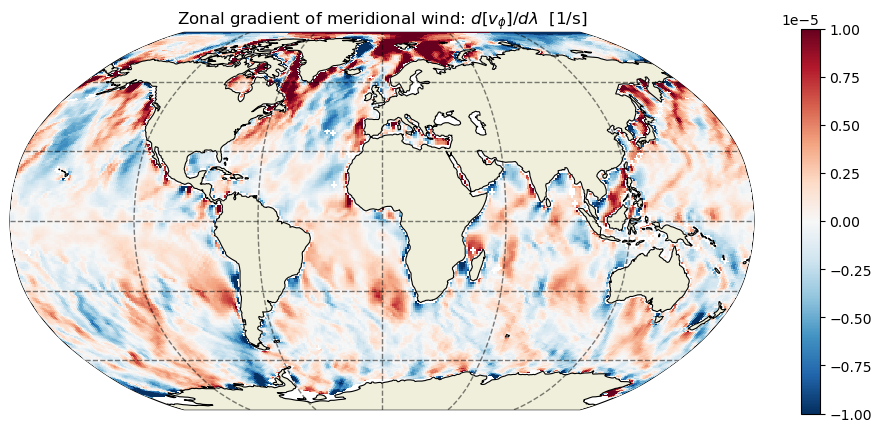

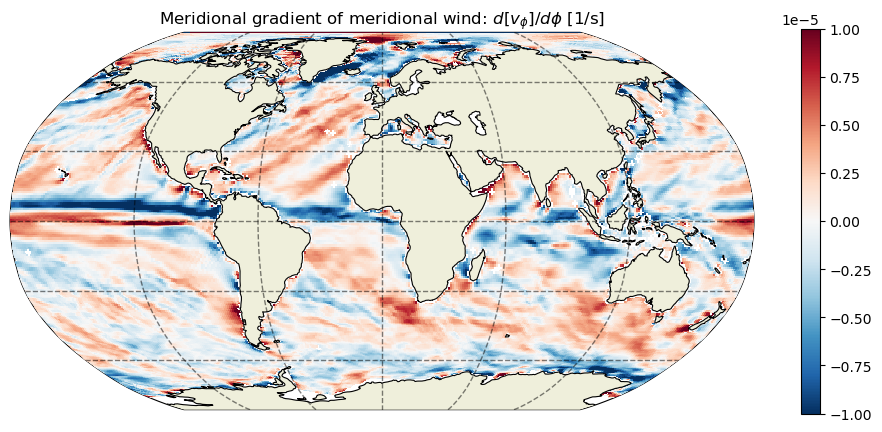

In [78]:
plt.figure(figsize=[12,5]);
m=-5
dx=0.5
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, dv_phi_dlambda,
                                  cmin=-10**m, cmax=10**m, cmap='RdBu_r', dx=dx,dy=dx,
                                  show_colorbar=True);
plt.title('Zonal gradient of meridional wind: $d[v_\phi]/d\lambda$  [1/s]');

plt.figure(figsize=[12,5]);
m=-5
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, dv_phi_dphi,
                                  cmin=-10**m, cmax=10**m, cmap='RdBu_r', dx=dx,dy=dx,
                                  show_colorbar=True);
plt.title('Meridional gradient of meridional wind: $d[v_\phi]/d\phi$ [1/s]');

### Wind curl

As we did with relative vorticity, we can use the computed gradients to plot the wind curl: $\bf{\omega} = \nabla\times\bf{u}$

$$\omega = \frac{\partial{v}}{\partial{x}} - \frac{\partial{u}}{\partial{y}}$$

For the $\partial{v}/\partial{x}$ term use the zonal gradient of meridional velocity,
`d_v_phi_dlambda` and for the $\partial{u}/\partial{y}$ term use the meridional gradient of zonal velocity,
`d_u_lambda_dphi`.

In [79]:
wind_curl = dv_phi_dlambda - du_lambda_dphi

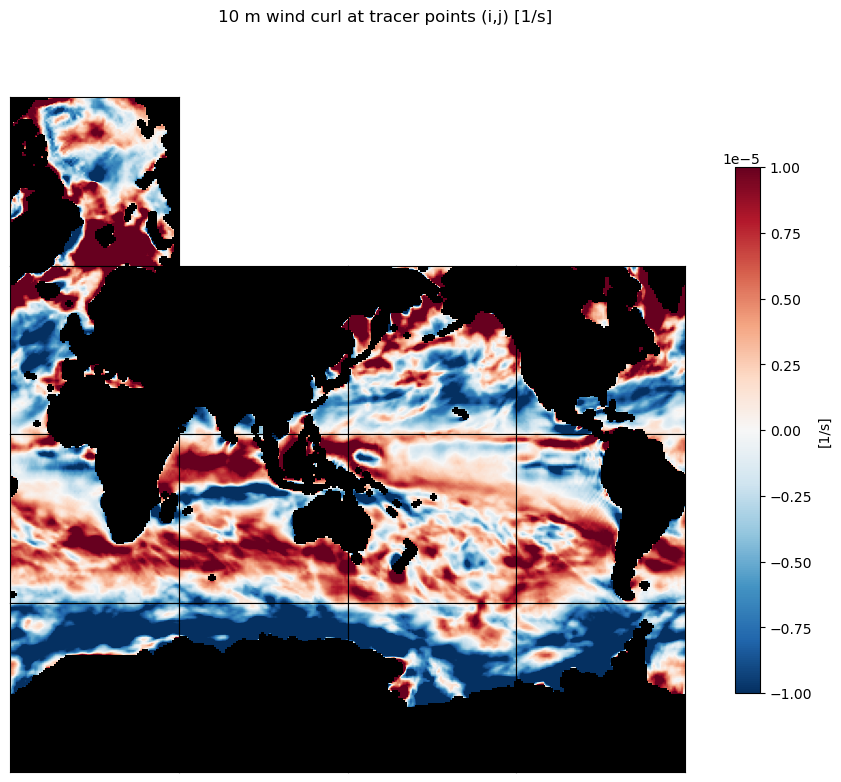

In [80]:
m=-5;
title='10 m wind curl at tracer points (i,j) [1/s]'
ecco.plot_tiles(wind_curl, cmin=-10**m, cmax=10**m,fig_size=10, 
                show_tile_labels=False, 
                rotate_to_latlon=True, layout='latlon',  cmap=colMap,
                show_colorbar=True, cbar_label='[1/s]', show_cbar_label=True);
plt.suptitle(title)
plt.show()

Exercise: repeat the above, but with ocean surface stress, to obtain maps of the surface stress curl from wind and sea-ice. How does it compare to the curl of the surface wind above?

> Hint: Replace `EXFuwind` and `EXFvwind` from the `ECCO_L4_ATM_STATE_LLC0090GRID_MONTHLY_V4R4` dataset with `oceTAUX` and `oceTAUY` from the `ECCO_L4_STRESS_LLC0090GRID_MONTHLY_V4R4` dataset.